In [8]:
#Mounting on co-lab
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

import sys
sys.path.insert(0,'/content/drive/My Drive/Interpretable_DNN') # change folder name


Mounted at /content/drive


#### Setup of the Environment

In [9]:
#!pip install --upgrade plotly
!pip install -q -U keras-tuner --quiet

In [10]:
#Import of Libaries

import os
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import math
import itertools
import pickle
from numpy.ma.core import argmax

#Data Preprocessing
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.cluster import KMeans


#Model Building and Explanations
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, backend, Model, callbacks
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.regularizers import l2
import keras_tuner as kt #hyperparameter tuning
from sklearn.metrics import confusion_matrix, classification_report,roc_auc_score
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go


#custom functions
from functions.data_proc import *
from functions.experiment_setup import *
from functions.generate_inputs import *


#### Functions

##### Model Building

In [11]:
#sigmoid activation function
# Instead of training another dense layer, we apply this directly upon the sum product of the thetas and explainable inputs to obtain the output

def sigmoid(x): 
    return 1.0/(1 + np.exp(-x))

#---------------------------------------------------------------------------------------------------------------------------

#Final Self Explaining Model

def self_explainable_model (indexes, args, exp_dim, lstm_size_alpha, lstm_size_beta, dense_1_dim, learning_rate, opt = None, max_len = None):

  EXPERIMENT = args['experiment']
  prefix_len = args['prefix_length']

  if  max_len == None:
    MAX_LEN = args['n_size']
  else:
    MAX_LEN = max_len


  incl_time = True 
  incl_res = True
    
  dropout = 0.15
  #lstm_size_alpha =  hp.Int('units', min_value=32, max_value=512, step=32) #50
  l2reg=0.0001
  dropout_input = 0.15
  dropout_context=0.15

  index_ac = indexes['index_ac']
  index_rl = indexes['index_rl']
  index_oc = indexes['index_oc']
  ac_index = indexes['ac_index']
  rl_index = indexes['rl_index']
  oc_index = indexes['oc_index']

  dim = len(ac_index)+ len(rl_index)+2

  #configuring the inputs

  raw_input = layers.Input(shape=(MAX_LEN,dim, ), name='raw_input') #Raw input x
 

  
  #raw_input = layers.Dropout(dropout)(raw_input)

  raw_input_static = layers.Input(shape = (1,), name = 'raw_input_static' ) #Static input x

  input = layers.Input(shape=(exp_dim, ), name='exp_input') #explainable input h(x)
  input = layers.Dropout(dropout,name='exp_input')(input)

  #LSTM layer with attention to process x

  alpha = layers.Bidirectional(layers.LSTM(lstm_size_alpha, return_sequences=True), name='alpha')
  
  alpha_dense = layers.Dense(1, kernel_regularizer=l2(l2reg))
  alpha_out = alpha(raw_input)  
  alpha_out = layers.TimeDistributed(alpha_dense, name='alpha_dense')(alpha_out)  
  alpha_out = layers.Softmax(name='timestep_attention', axis=1)(alpha_out)
  
  #second LSTM layer with attention to process x - sequential
  
  beta = layers.Bidirectional(layers.LSTM(lstm_size_beta, return_sequences=True),
                                        name='beta')
  beta_dense = layers.Dense(dim,
                             activation='tanh', kernel_regularizer=l2(l2reg))
  beta_out = beta(raw_input)  
  beta_out = layers.TimeDistributed(beta_dense, name='beta_dense')(beta_out)  
  #beta_out = layers.Softmax(name='beta_timestep_attention', axis=1)(beta_out)
  
  #Compute context vector based on attentions and raw input x
  c_t = layers.Multiply()([alpha_out, beta_out, raw_input])
  c_t = layers.Lambda(lambda x: backend.sum(x, axis=1))(c_t)
  c_t = layers.concatenate([c_t,raw_input_static],name = 'full_features')

  #contexts = layers.Dropout(dropout)(c_t)

  #Intermediate dense layer
  dense_1_dim = round(exp_dim*dense_1_dim) 

  dense_1 = layers.Dense(dense_1_dim,
                        activation='softmax',
                        kernel_initializer='glorot_uniform',
                        name='dense_1')(c_t)

  #Dense layer to compute the explainable weights thetas

  thetas = layers.Dense(exp_dim,
                        activation='softmax',
                        kernel_initializer='glorot_uniform',
                        name='explanation_weights')(dense_1)
  #Regression layer

  reg = layers.Multiply(name = 'regression_input')([thetas, input])
  #x = layers.Lambda(lambda x: backend.sum(x, axis=1))(reg)
  #reg = layers.Dropout(dropout)(reg)

  #outcome_dim = vec['outcome'].shape[1]

  #Final Output
  #act_output = tf.math.sigmoid(x, name='act_output')

  #initialize all the weights to one
  initializer = tf.keras.initializers.Ones()  
  act_output = layers.Dense(1,activation='sigmoid',kernel_initializer=initializer,trainable=True, name='act_output')(reg)


  model = Model(inputs=[raw_input, raw_input_static, input], outputs=[thetas,act_output])

  plot_model(
        model,
        to_file="self explainable model.png",
        show_shapes=False,
        show_dtype=False,
        show_layer_names=True,
        rankdir="TB",
        expand_nested=False,
        dpi=96,
    )
  #learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  #optimizer choice

  if opt == 'Adam':
    optim = keras.optimizers.Adam(learning_rate=learning_rate)
  elif opt == 'Nadam':
    optim = keras.optimizers.Nadam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
  elif opt == 'Adamax':
    optim = keras.optimizers.Adamax(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
  elif opt == 'Adagrad':
    optim = keras.optimizers.Adagrad(learning_rate=learning_rate, initial_accumulator_value=0.1, epsilon=1e-07)
  else:
     optim = keras.optimizers.Adam(learning_rate=learning_rate) 




  model.compile(loss={'act_output': 'binary_crossentropy'}, optimizer= optim , metrics=['accuracy']) 
  
  
  return model



#Hyperparameter tuning and returning the best model

def self_explainable_model_optimum (input_train,output_train,indexes, args, exp_dim, opt = None , max_len = None):

  if opt == None:
    opt = 'Adam'

  def model_builder(hp):

    lstm_size_alpha =  hp.Int('units', min_value=10, max_value=250, step=10)
    lstm_size_beta = hp.Int('units_beta', min_value=10, max_value=250, step=10)
    dense_1_dim = hp.Choice('units_dense_1', values=[1.2, 1.5, 2.0])
    learning_rate = 1e-2 #hp.Choice('learning_rate', values=[1e-2, 1e-3])

    model = self_explainable_model(indexes, args, exp_dim, lstm_size_alpha, lstm_size_beta, dense_1_dim, learning_rate, opt, max_len)
    return model
  
  objective_fn =kt.Objective("val_act_output_accuracy", direction="max")

  tuner = kt.Hyperband(model_builder,
                     objective=objective_fn,
                     max_epochs=10,
                     factor=3,
                     directory=MY_WORKSPACE_DIR,
                     overwrite=True)
  
  early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=10)

  tuner.search([input_train['input_dynamic'],input_train['input_static'],input_train['input_exp']], [output_train['w_output'],output_train['act_output']], epochs=50, validation_split=0.2, callbacks=[early_stopping])

  best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

  model = tuner.hypermodel.build(best_hps)
  print(model.summary())

  return model

#Training the model

def self_explainable_model_fit(input_train,output_train,args, self_explainable_model, MY_WORKSPACE_DIR, batch_size, epochs):


  early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=100)

  output_file_path = os.path.join(os.path.join(MY_WORKSPACE_DIR,
                                        'models'),'model_' +args['prediction']+
                                        '_{epoch:02d}-{val_loss:.2f}.h5')
  
  lr_reducer = callbacks.ReduceLROnPlateau(monitor='val_loss',
                                    factor=0.5,
                                    patience=20,
                                    verbose=0,
                                    mode='auto',
                                    min_delta=0.0001,
                                    cooldown=0,
                                    min_lr=0)
  
  

  model_history = self_explainable_model.fit([input_train['input_dynamic'],input_train['input_static'],input_train['input_exp']], [output_train['w_output'],output_train['act_output']],
              validation_split=0.15,
              #validation_data=(model_val_inputs, model_val_outputs),
              verbose=1,
              callbacks=[lr_reducer], #callbacks=[early_stopping, model_checkpoint,lr_reducer],
              batch_size=batch_size,
              epochs=epochs)
  
  return model_history
   
#-----------------------------------------------------------------------------------------------------------------------------------------------
#Plot Model History
def plot_model_history(history):
    #Training and validation curves

    plt.plot(history.history['act_output_accuracy'])
    plt.plot(history.history['val_act_output_accuracy'])
    plt.title('explainable model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()






##### Model Testing and Explanations



In [12]:

#-----------------------------------------------------------------------------------------------------------------------------------------------
#Model Testing

def test_model(input_test, output_test, exp_dim, features_exp,self_explainable_model,index_oc):

  print("Evaluate on test data")
  results = self_explainable.evaluate([input_test['input_dynamic'],input_test['input_static'],input_test['input_exp']], [output_test['w_output'],output_test['act_output']], batch_size=100)
  print("test loss, test acc:", results)
  print("\n")

  print("Classification Report")
  target_names = [index_oc[i] for i in range(len(index_oc))]
  y_test = output_test['act_output']
  y_out = self_explainable.predict([input_test['input_dynamic'],input_test['input_static'],input_test['input_exp']])
  y_pred = y_out[1]
  y_pred_bin = y_pred > 0.5
  y_pred_bin = y_pred_bin.astype(int)

  report = classification_report(y_test, y_pred_bin , target_names=target_names, output_dict=True)
  print("\n")

  '''print("Confusion Matrix")
  matrix = confusion_matrix(y_test, y_pred_bin )

  matrix_sum = np.sum(matrix, axis=1).reshape(-1,1)
  matrix_perc = matrix / matrix_sum
  df_cm = pd.DataFrame(matrix_perc, index = target_names,
                  columns = target_names)

  plt.figure(figsize = (10,7))
  sn.heatmap(df_cm, annot=True)'''

  return report

#-----------------------------------------------------------------------------------------------------------------------------------------------
#Model Outputs

def model_outputs(input_test, output_test, exp_dim, features_exp,self_explainable_model):


  y_out = self_explainable_model.predict([input_test['input_dynamic'],input_test['input_static'],input_test['input_exp']])

  y_test = output_test['act_output']
  y_pred = y_out[1]
  y_pred_bin = y_pred > 0.5
  y_pred_bin = y_pred_bin.astype(int)
  y_test_exp = y_out[0]

  model_output_test ={}
  model_output_test['y_test'] = y_test
  model_output_test['y_pred'] = y_pred
  model_output_test['y_pred_bin'] = y_pred_bin
  model_output_test['y_test_exp'] = y_test_exp

  return input_test, model_output_test, features_exp



#-----------------------------------------------------------------------------------------------------------------------------------------------
#an array which identifies the closest input to the each input in the training set to compute the custom loss function

def closest_input(inputs):

  model_input_exp = inputs['input_exp']
  
  closest_input = []
  for i, x in enumerate(model_input_exp):
    error = 1000
    ind = 0
    if i == model_input_exp.shape[0]:
      for j, x_d in enumerate(model_input_exp):
        temp_error = backend.mean(backend.square(x- x_d))
        temp_ind = j
        if error > temp_error:
            error = temp_error
            ind = temp_ind
    else:
      for j, x_d in enumerate(model_input_exp[i+1:]):
        temp_error = backend.mean(backend.square(x- x_d))
        temp_ind = j+i+1
      
        if error > temp_error:
            error = temp_error
            ind = temp_ind
    closest_input = np.append(closest_input,[ind],axis = 0)

  closest_input = closest_input.astype(int)
  return closest_input



#### Experiment

##### Setting up experiment parameters

In [17]:
#Experimental parameters
prediction = 'Outcome' 
experiment =  'AG' #'IX'
timelapsed = 'total'
exp = 'EXP_2' #'EXP_0': old architecture, 'EXP_1': new architecture, 'EXP_2': Imbalanced test set

#Directories
MY_WORKSPACE_DIR = "/content/drive/My Drive/Interpretable_DNN/BPIC12_v2"
MILESTONE_DIR = "/content/drive/My Drive/Interpretable_DNN/BPIC12_v2/"+exp+'/'+experiment+'/'

#Dataset
file_name = os.path.join(MY_WORKSPACE_DIR,'BPIC_2012_MILESTONE_BASED_OUTCOME_EXTENDED.csv')
log_name = 'bpic_2012'


#saving parameters to a dictionary
args = get_parameters(MILESTONE_DIR, MY_WORKSPACE_DIR, prediction, experiment, file_name, log_name,exp)



##### Data Preprocessing



In [18]:
#Load data

log_df = pd.read_csv(args['file_name'])
log_df = log_df.reset_index(drop=True)


In [19]:
log_col = log_df.columns.tolist()
log_col.append('BUCKET')
log_col

['CASEID',
 'MILESTONE',
 'RESOURCE',
 'TASK_DURATION',
 'TIME_ELAPSED',
 'END_TIMESTAMP',
 'ACTIVITY_INDEX',
 'AMOUNT_REQ',
 'OUTCOME',
 'TRACE_END',
 'A_SUBMITTED_BUCKET',
 'A_ACCEPTED_BUCKET',
 'A_FINALIZED_BUCKET',
 'O_SENT_BUCKET',
 'W_COMPLETE_LEADS_CT',
 'W_COMPLETE_PREACCEPTED_APPLICATIONS_CT',
 'W_FOLLOWUP_MISSING_INFO_CT',
 'W_FOLLOWUP_OFFER_CT',
 'W_INVESTIGATING_FOR_FRAUD_CT',
 'W_MODIFYING_EXISTING_CONTRACTS_CT',
 'BUCKET']

In [20]:
#split test train
log_df_train, log_df_test = split_train_test(log_df, 0.3)

In [21]:

#Bucketing
n_size_ls = [5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]

def split_bucket(log_df,log_col):
  log_df_temp = pd.DataFrame(columns = log_col)

  for i in range(len(n_size_ls)):
    df_temp = extract_prefixes(log_df,1,n_size_ls[i])
    df_temp['BUCKET'] = str(1)+'_'+str(n_size_ls[i])
    log_df_temp = pd.concat([log_df_temp,df_temp])

  return log_df_temp 

log_df_train = split_bucket(log_df_train,log_col)
log_df_test = split_bucket(log_df_test,log_col)

#Add new column to identify the resource label
log_df_train['RESOURCE'] = 'RES_' + log_df_train['RESOURCE'].astype(int,errors = 'ignore').astype(str,errors = 'ignore')
log_df_test['RESOURCE'] = 'RES_' + log_df_test['RESOURCE'].astype(int,errors = 'ignore').astype(str,errors = 'ignore')

log_df_train.head()

<ipython-input-21-07330baf02ef>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['BUCKET'] = str(1)+'_'+str(n_size_ls[i])


CASEID          MILESTONE     RESOURCE TASK_DURATION TIME_ELAPSED  \
0  173688  A_PARTLYSUBMITTED    RES_112.0             0            0   
1  173688        A_SUBMITTED    RES_112.0             0            0   
2  173688      A_PREACCEPTED    RES_112.0             1            0   
3  173688         A_ACCEPTED  RES_10862.0           663            1   
4  173688        A_FINALIZED  RES_10862.0             0          667   

                        END_TIMESTAMP ACTIVITY_INDEX AMOUNT_REQ     OUTCOME  \
0  2011-10-01 08:38:44.8800000 +10:00              1      20000  A_APPROVED   
1  2011-10-01 08:38:44.5460000 +10:00              2      20000  A_APPROVED   
2  2011-10-01 08:39:37.9060000 +10:00              3      20000  A_APPROVED   
3  2011-10-01 19:42:43.3080000 +10:00              4      20000  A_APPROVED   
4  2011-10-01 19:45:09.2430000 +10:00              5      20000  A_APPROVED   

  TRACE_END  ... A_ACCEPTED_BUCKET A_FINALIZED_BUCKET O_SENT_BUCKET  \
0         0  ...                 1                  1             1   
1         0  ...                 1                  1             1   
2         0  ...                 1                  1             1   
3         0  ...                 1                  1             1   
4         0  ...                 0                  1             1   

  W_COMPLETE_LEADS_CT W_COMPLETE_PREACCEPTED_APPLICATIONS_CT  \
0                   0                                      1   
1                   0                                      1   
2                   0                                      1   
3                   0                                      1   
4                   0                                      1   

  W_FOLLOWUP_MISSING_INFO_CT W_FOLLOWUP_OFFER_CT W_INVESTIGATING_FOR_FRAUD_CT  \
0                          0                   3                            0   
1                          0                   3                            0   
2                          0                   3                            0   
3                          0                   3                            0   
4                          0                   3                            0   

  W_MODIFYING_EXISTING_CONTRACTS_CT BUCKET  
0                                 0    1_5  
1                                 0    1_5  
2                                 0    1_5  
3                                 0    1_5  
4                                 0    1_5  

[5 rows x 21 columns]

In [22]:
buckets = log_df_train['BUCKET'].unique().tolist()

for bucket in buckets:
  print(bucket)
  print('training dataset')
  print(log_df_train[log_df_train['BUCKET'] == bucket].groupby(['OUTCOME'])['CASEID'].nunique())
  print("")
  print('test dataset')
  print(log_df_test[log_df_test['BUCKET'] == bucket].groupby(['OUTCOME'])['CASEID'].nunique())
  print("")






1_5
training dataset
OUTCOME
A_APPROVED    1582
A_DECLINED    1871
Name: CASEID, dtype: int64

test dataset
OUTCOME
A_APPROVED    664
A_DECLINED    834
Name: CASEID, dtype: int64

1_6
training dataset
OUTCOME
A_APPROVED    1582
A_DECLINED    1709
Name: CASEID, dtype: int64

test dataset
OUTCOME
A_APPROVED    664
A_DECLINED    755
Name: CASEID, dtype: int64

1_7
training dataset
OUTCOME
A_APPROVED    1582
A_DECLINED    1701
Name: CASEID, dtype: int64

test dataset
OUTCOME
A_APPROVED    664
A_DECLINED    748
Name: CASEID, dtype: int64

1_8
training dataset
OUTCOME
A_APPROVED    1582
A_DECLINED    1698
Name: CASEID, dtype: int64

test dataset
OUTCOME
A_APPROVED    664
A_DECLINED    746
Name: CASEID, dtype: int64

1_9
training dataset
OUTCOME
A_APPROVED    1582
A_DECLINED    1587
Name: CASEID, dtype: int64

test dataset
OUTCOME
A_APPROVED    664
A_DECLINED    689
Name: CASEID, dtype: int64

1_10
training dataset
OUTCOME
A_APPROVED    1525
A_DECLINED    1264
Name: CASEID, dtype: int64

test

In [23]:
#Balance only the training set and check the balance
log_df_train_temp = pd.DataFrame(columns = log_col)

for i in range(len(buckets)):
  df_temp = log_df_train[log_df_train['BUCKET'] == buckets[i]]
  a = df_temp.groupby(['OUTCOME'])['CASEID'].nunique().reset_index()
  min_ind = np.argmin(a['CASEID'])
  min_target = a['OUTCOME'][min_ind]

  df_temp = balance(df_temp,'OUTCOME',min_target,'CASEID')
  log_df_train_temp = pd.concat([log_df_train_temp,df_temp])

log_df_train = log_df_train_temp

for bucket in buckets:
  print(bucket)
  print('training dataset')
  print(log_df_train[log_df_train['BUCKET'] == bucket].groupby(['OUTCOME'])['CASEID'].nunique())
  print("")
  print('test dataset')
  print(log_df_test[log_df_test['BUCKET'] == bucket].groupby(['OUTCOME'])['CASEID'].nunique())
  print("")

1_5
training dataset
OUTCOME
A_APPROVED    1582
A_DECLINED    1582
Name: CASEID, dtype: int64

test dataset
OUTCOME
A_APPROVED    664
A_DECLINED    834
Name: CASEID, dtype: int64

1_6
training dataset
OUTCOME
A_APPROVED    1582
A_DECLINED    1582
Name: CASEID, dtype: int64

test dataset
OUTCOME
A_APPROVED    664
A_DECLINED    755
Name: CASEID, dtype: int64

1_7
training dataset
OUTCOME
A_APPROVED    1582
A_DECLINED    1582
Name: CASEID, dtype: int64

test dataset
OUTCOME
A_APPROVED    664
A_DECLINED    748
Name: CASEID, dtype: int64

1_8
training dataset
OUTCOME
A_APPROVED    1582
A_DECLINED    1582
Name: CASEID, dtype: int64

test dataset
OUTCOME
A_APPROVED    664
A_DECLINED    746
Name: CASEID, dtype: int64

1_9
training dataset
OUTCOME
A_APPROVED    1582
A_DECLINED    1582
Name: CASEID, dtype: int64

test dataset
OUTCOME
A_APPROVED    664
A_DECLINED    689
Name: CASEID, dtype: int64

1_10
training dataset
OUTCOME
A_APPROVED    1264
A_DECLINED    1264
Name: CASEID, dtype: int64

test

In [24]:
#Feature Encoding

def encode_features(log_df_train,log_df_test):

  #------------------------------------------------------------------------------------------------
  #Role discovery
  #Discover roles with the training dataset

  resources, act_res_train , act_res_test = role_discovery_inputs(log_df_train,log_df_test)
  roles, log_df_train = discover_roles(resources,act_res_train,log_df_train)

  #assign roles 
  log_df_test = assign_roles(roles,resources,act_res_test,log_df_test)

  #log_df_test.head()
  #------------------------------------------------------------------------------------------------
  #Index Encoding Categorical Features

  # Index creation for activity
  ac_index = create_index(log_df_train, 'MILESTONE')
  index_ac = {v: k for k, v in ac_index.items()}

  # Index creation for role
  rl_index = create_index(log_df_train, 'ROLE')
  index_rl = {v: k for k, v in rl_index.items()}

  # Index creation for outcome
  oc_index = create_index(log_df_train, 'OUTCOME')
  index_oc = {v: k for k, v in oc_index.items()}

  #mapping the dictionary values as columns in the dataframe - train set
  log_df_train['ac_index'] = log_df_train['MILESTONE'].map(ac_index,0)
  log_df_train['rl_index'] = log_df_train['ROLE'].map(rl_index,0)
  log_df_train['oc_index'] = log_df_train['OUTCOME'].map(oc_index,0)

  #mapping the dictionary values as columns in the dataframe - test set
  log_df_test['ac_index'] = log_df_test['MILESTONE'].map(ac_index,0)
  log_df_test['rl_index'] = log_df_test['ROLE'].map(rl_index,0)
  log_df_test['oc_index'] = log_df_test['OUTCOME'].map(oc_index,0)

  #------------------------------------------------------------------------------------------------
  #Normalizing Numerical features
  numerical_features = ['TASK_DURATION','TIME_ELAPSED','AMOUNT_REQ']

  log_df_train = normalize_events(log_df_train,args,numerical_features)
  log_df_test = normalize_events(log_df_test,args,numerical_features)

  return log_df_train, log_df_test, ac_index, index_ac, rl_index, index_rl, oc_index, index_oc

indexes = {}


for i in range(len(buckets)):
  df_train = log_df_train[log_df_train['BUCKET'] == buckets[i]]
  df_test = log_df_test[log_df_test['BUCKET'] == buckets[i]]  
  

  if i == 0: 
      log_df_train_temp, log_df_test_temp, ac_index, index_ac, rl_index, index_rl, oc_index, index_oc = encode_features(df_train,df_test)
      bucket_index = {}
      bucket_index['ac_index'] = ac_index
      bucket_index['index_ac'] = index_ac
      bucket_index['rl_index'] = rl_index
      bucket_index['index_rl'] = index_rl
      bucket_index['oc_index'] = oc_index
      bucket_index['index_oc'] = index_oc
      indexes[str(buckets[i])] = bucket_index
  else:
      df_train, df_test, ac_index, index_ac, rl_index, index_rl, oc_index, index_oc = encode_features(df_train,df_test)

      bucket_index = {}
      bucket_index['ac_index'] = ac_index
      bucket_index['index_ac'] = index_ac
      bucket_index['rl_index'] = rl_index
      bucket_index['index_rl'] = index_rl
      bucket_index['oc_index'] = oc_index
      bucket_index['index_oc'] = index_oc
      indexes[str(buckets[i])] = bucket_index
      
      log_df_train_temp = pd.concat([log_df_train_temp,df_train])
      log_df_test_temp = pd.concat([log_df_test_temp,df_test])


log_df_train = log_df_train_temp.fillna(0) 
log_df_test = log_df_test_temp.fillna(0) 

In [25]:
#Get the non-milestone activities
non_milestone_acts = ['W_COMPLETE_LEADS','W_COMPLETE_PREACCEPTED_APPLICATIONS','W_INVESTIGATING_FOR_FRAUD','W_FOLLOWUP_MISSING_INFO']
non_milestone_ind =[]
for i in range(len(buckets)):
  non_milestones =[]
  for nms in non_milestone_acts:
    nms_ind = indexes[buckets[i]]['ac_index'].get(nms)
    if nms_ind != None:
      non_milestones.append(nms_ind)
  indexes[buckets[i]]['non_milestones'] = non_milestones
  non_milestone_ind.append(non_milestones)


In [26]:
non_milestone_ind

[[6, 7, 8],
 [7, 8, 9],
 [7, 8, 9],
 [9, 10, 12],
 [9, 10, 12],
 [10, 11, 13],
 [10, 11, 14, 12],
 [10, 11, 14, 12],
 [10, 11, 14, 12],
 [10, 11, 14, 12],
 [10, 11, 14, 12],
 [10, 11, 14, 12],
 [10, 11, 14, 12],
 [10, 11, 14, 12],
 [10, 11, 14, 12],
 [10, 11, 14, 12]]

In [27]:
#Vectorization

full_vec = {}

for i in range(len(buckets)):

  vec = {}

  df_train = log_df_train[log_df_train['BUCKET']==buckets[i]]
  df_test = log_df_test[log_df_test['BUCKET']==buckets[i]]

  print(buckets[i])

  #Reformating the event log
  log_train = reformat_events(df_train, ac_index, rl_index,oc_index)
  log_test = reformat_events(df_test, ac_index, rl_index,oc_index)

  #Obtain the maximum trc_len and cases for each set
  trc_len_train, cases_train = lengths(log_train)
  trc_len_test, cases_test = lengths(log_test)

  trc_len = max([trc_len_train, trc_len_test])
  print("trace_length: "+str(trc_len)+", training cases: "+str(cases_train)+", test cases: "+str(cases_test) )

  #Converting the log into a 3D Tensor
  vec_train = vectorization(log_train,ac_index, rl_index, oc_index,trc_len,cases_train)
  vec_test = vectorization(log_test,ac_index, rl_index, oc_index,trc_len,cases_test)

  vec['vec_train'] = vec_train
  vec['vec_test'] = vec_test

  full_vec[buckets[i]] = vec
  

  indexes[buckets[i]]['trc_len'] = trc_len
  indexes[buckets[i]]['cases_train'] = cases_train
  indexes[buckets[i]]['cases_test'] = cases_test


1_5
trace_length: 5, training cases: 3164, test cases: 1498
1_6
trace_length: 6, training cases: 3164, test cases: 1419
1_7
trace_length: 7, training cases: 3164, test cases: 1412
1_8
trace_length: 8, training cases: 3164, test cases: 1410
1_9
trace_length: 9, training cases: 3164, test cases: 1353
1_10
trace_length: 10, training cases: 2528, test cases: 1164
1_11
trace_length: 11, training cases: 1924, test cases: 944
1_12
trace_length: 12, training cases: 1492, test cases: 738
1_13
trace_length: 13, training cases: 1028, test cases: 542
1_14
trace_length: 14, training cases: 696, test cases: 373
1_15
trace_length: 15, training cases: 490, test cases: 274
1_16
trace_length: 16, training cases: 348, test cases: 208
1_17
trace_length: 17, training cases: 228, test cases: 148
1_18
trace_length: 18, training cases: 154, test cases: 115
1_19
trace_length: 19, training cases: 88, test cases: 84
1_20
trace_length: 20, training cases: 64, test cases: 54


##### Saving Processed Data and Parameters

In [29]:
# saving the processed tensor
dirname = os.path.dirname(args['processed_vec'])
if not os.path.exists(dirname):
    os.makedirs(dirname)
with open(args['processed_vec'], 'wb') as fp:
    pickle.dump(full_vec, fp, protocol=pickle.HIGHEST_PROTOCOL)

# saving indexes
with open(args['indexes'], 'wb') as fp:
    pickle.dump(indexes, fp, protocol=pickle.HIGHEST_PROTOCOL)

#converting bucket info into a dictionary and saving
bucket_info = {}
bucket_info['buckets'] = buckets
bucket_info['n_size_ls'] = n_size_ls
bucket_info['non_milestones'] = non_milestone_ind
with open(args['bucket_info'], 'wb') as fp:
    pickle.dump(bucket_info, fp, protocol=pickle.HIGHEST_PROTOCOL)


#saving the arguements (args)
with open(args['args'], 'wb') as fp:
    pickle.dump(args, fp, protocol=pickle.HIGHEST_PROTOCOL)

#saving event log files
file_name_train_log = os.path.join(MY_WORKSPACE_DIR+'/'+exp,'BPIC_2012_log_df_train.csv')
log_df_train.to_csv(file_name_train_log)

file_name_test_log = os.path.join(MY_WORKSPACE_DIR+'/'+exp,'BPIC_2012_log_df_test.csv')
log_df_test.to_csv(file_name_test_log)




##### Retrieving Saved Data and Parameters

In [ ]:
with open(args['processed_vec'], 'rb') as fp:
    full_vec = pickle.load(fp)

with open(args['indexes'], 'rb') as fp:
    indexes = pickle.load(fp)

with open(args['bucket_info'], 'rb') as fp:
    bucket_info = pickle.load(fp)

file_name_train_log = os.path.join(MY_WORKSPACE_DIR+'/'+exp,'BPIC_2012_log_df_train.csv')
log_df_train = pd.read_csv(file_name_train_log)

file_name_test_log = os.path.join(MY_WORKSPACE_DIR+'/'+exp,'BPIC_2012_log_df_test.csv')
log_df_test = pd.read_csv(file_name_test_log)

##### Generating Inputs

In [30]:
buckets = bucket_info['buckets']
non_milestones = bucket_info['non_milestones']

inputs_outputs = {} #Final Dictionary with Test and Train Inputs/ Outputs for all buckets

for i in range(len(buckets)):

  vec_train = full_vec[buckets[i]]['vec_train']
  vec_test = full_vec[buckets[i]]['vec_test']

  #removing amt_req feature

  #vec_train['statics']['amt_req'] =  np.absolute(vec_train['statics']['amt_req'])*0
  #vec_test['statics']['amt_req'] =  np.absolute(vec_test['statics']['amt_req'])*0
  
  

  bucket = buckets[i]
  bucket_inputs_outputs  = {}

  #Inputs and Outputs -- select depending on the encoding technique
  if experiment == 'AG': 
    inputs_train, outputs_train, input_exp_dim_train, features_exp_train = generate_inputs_AG(vec_train,args,indexes[bucket],non_milestones[i],bucket_info,i)
    inputs_test, outputs_test, input_exp_dim_test, features_exp_test = generate_inputs_AG(vec_test,args,indexes[bucket],non_milestones[i],bucket_info,i)

  if experiment == 'AG_LS': 
    inputs_train, outputs_train, input_exp_dim_train, features_exp_train = generate_inputs_AG_LS(vec_train,args,indexes[bucket],non_milestones[i],bucket_info,i)
    inputs_test, outputs_test, input_exp_dim_test, features_exp_test = generate_inputs_AG_LS(vec_test,args,indexes[bucket],non_milestones[i],bucket_info,i)
  
  if experiment == 'MS': 
    inputs_train, outputs_train, input_exp_dim_train, features_exp_train = generate_inputs_MS(vec_train,args,indexes[bucket],non_milestones[i],bucket_info,i)
    inputs_test, outputs_test, input_exp_dim_test, features_exp_test = generate_inputs_MS(vec_test,args,indexes[bucket],non_milestones[i],bucket_info,i)
  
  if experiment == 'IX': 
    inputs_train, outputs_train, input_exp_dim_train, features_exp_train = generate_inputs_IX(vec_train,args,indexes[bucket],non_milestones[i],bucket_info,i)
    inputs_test, outputs_test, input_exp_dim_test, features_exp_test = generate_inputs_IX(vec_test,args,indexes[bucket],non_milestones[i],bucket_info,i)

  features_exp = features_exp_train
  input_exp_dim = input_exp_dim_train
  if len(features_exp_test) > len(features_exp_train):
    features_exp = features_exp_test
    input_exp_dim = input_exp_dim_test

    #if training feature dimensionality < test feature dimensionalty, reshape the training feature dimensionality (this can happen when sample size is too small)
    input_exp_temp =[]
    for i in range(inputs_train['input_exp'].shape[0]):
      feat =[]
      k = 0
      for j in range(len(features_exp)):
        if features_exp[j] == features_exp_train[k]:
          feat.append(inputs_train['input_exp'][i][k])
          k = k+1
        else:
          feat.append(0)
      input_exp_temp.append(feat)
    input_exp_temp = np.asarray(input_exp_temp) 
    inputs_train['input_exp'] = input_exp_temp

  if len(features_exp_test) < len(features_exp_train):
    #if test feature dimensionality < training feature dimensionalty, reshape the test feature dimensionality (this can happen when sample size is too small)
    input_exp_temp =[]
    for i in range(inputs_test['input_exp'].shape[0]):
      feat =[]
      k = 0
      for j in range(len(features_exp)):
        if features_exp[j] == features_exp_test[k]:
          feat.append(inputs_test['input_exp'][i][k])
          k = k+1
        else:
          feat.append(0)
      input_exp_temp.append(feat)
    input_exp_temp = np.asarray(input_exp_temp) 
    inputs_test['input_exp'] = input_exp_temp

  bucket_inputs_outputs['inputs_train'] = inputs_train
  bucket_inputs_outputs['inputs_test'] = inputs_test
  bucket_inputs_outputs['outputs_train'] = outputs_train
  bucket_inputs_outputs['outputs_test'] = outputs_test
  bucket_inputs_outputs['explainable_feature_names'] = features_exp
  bucket_inputs_outputs['input_exp_dim'] = input_exp_dim

  inputs_outputs[bucket] = bucket_inputs_outputs

  dynamic_dim = bucket_inputs_outputs['inputs_train']['input_dynamic'].shape[2]
  try: static_dim = bucket_inputs_outputs['inputs_train']['input_static'].shape[1]
  except: static_dim  = 1

  print(bucket+' done!')
  print(dynamic_dim)
  print(static_dim)
  print(input_exp_dim)



1_5 done!
17
1
16
1_6 done!
18
1
17
1_7 done!
18
1
17
1_8 done!
21
1
20
1_9 done!
21
1
20
1_10 done!
22
1
21
1_11 done!
23
1
22
1_12 done!
23
1
22
1_13 done!
23
1
22
1_14 done!
23
1
22
1_15 done!
23
1
22
1_16 done!
23
1
22
1_17 done!
23
1
22
1_18 done!
23
1
22
1_19 done!
23
1
22
1_20 done!
23
1
22


### Model Building And Explaining


Epoch 1/200
3/3 [==============================] - 11s 1s/step - loss: 0.7318 - act_output_loss: 0.7289 - explanation_weights_accuracy: 0.0000e+00 - act_output_accuracy: 0.5110 - val_loss: 0.7670 - val_act_output_loss: 0.7648 - val_explanation_weights_accuracy: 0.0000e+00 - val_act_output_accuracy: 0.4379 - lr: 0.0100
Epoch 2/200
3/3 [==============================] - 0s 121ms/step - loss: 0.7204 - act_output_loss: 0.7185 - explanation_weights_accuracy: 0.0000e+00 - act_output_accuracy: 0.5110 - val_loss: 0.7512 - val_act_output_loss: 0.7500 - val_explanation_weights_accuracy: 0.0000e+00 - val_act_output_accuracy: 0.4379 - lr: 0.0100
Epoch 3/200
3/3 [==============================] - 0s 116ms/step - loss: 0.7110 - act_output_loss: 0.7099 - explanation_weights_accuracy: 0.0000e+00 - act_output_accuracy: 0.5110 - val_loss: 0.7382 - val_act_output_loss: 0.7375 - val_explanation_weights_accuracy: 0.0000e+00 - val_act_output_accuracy: 0.4379 - lr: 0.0100
Epoch 4/200
3/3 [===================

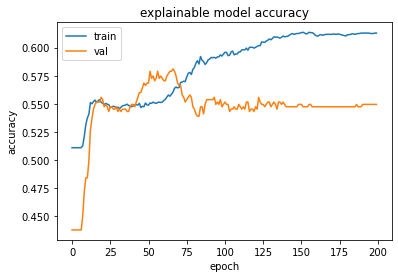

Evaluate on test data
15/15 [==============================] - 0s 9ms/step - loss: 0.6981 - act_output_loss: 0.6967 - explanation_weights_accuracy: 0.0000e+00 - act_output_accuracy: 0.5314
test loss, test acc: [0.6980817317962646, 0.6966552734375, 0.0, 0.5313751697540283]


Classification Report
47/47 [==============================] - 2s 4ms/step


47/47 [==============================] - 0s 4ms/step
Epoch 1/200
3/3 [==============================] - 11s 1s/step - loss: 0.7441 - act_output_loss: 0.7411 - explanation_weights_accuracy: 0.0149 - act_output_accuracy: 0.5102 - val_loss: 0.7807 - val_act_output_loss: 0.7786 - val_explanation_weights_accuracy: 0.0000e+00 - val_act_output_accuracy: 0.4421 - lr: 0.0100
Epoch 2/200
3/3 [==============================] - 0s 116ms/step - loss: 0.7300 - act_output_loss: 0.7281 - explanation_weights_accuracy: 0.0000e+00 - act_output_accuracy: 0.5102 - val_loss: 0.7632 - val_act_output_loss: 0.7619 - val_explanation_weights_accuracy: 0.0000e+00 - va

Evaluate on test data
15/15 [==============================] - 0s 9ms/step - loss: 0.6926 - act_output_loss: 0.6920 - explanation_weights_accuracy: 0.0000e+00 - act_output_accuracy: 0.5356
test loss, test acc: [0.692577600479126, 0.6919816136360168, 0.0, 0.5355884432792664]


Classification Report
45/45 [==============================] - 2s 4ms/step


45/45 [==============================] - 0s 5ms/step
Epoch 1/200
3/3 [==============================] - 11s 2s/step - loss: 0.7631 - act_output_loss: 0.7601 - explanation_weights_accuracy: 0.0000e+00 - act_output_accuracy: 0.5095 - val_loss: 0.8008 - val_act_output_loss: 0.7986 - val_explanation_weights_accuracy: 0.0000e+00 - val_act_output_accuracy: 0.4463 - lr: 0.0100
Epoch 2/200
3/3 [==============================] - 0s 128ms/step - loss: 0.7460 - act_output_loss: 0.7441 - explanation_weights_accuracy: 0.0000e+00 - act_output_accuracy: 0.5095 - val_loss: 0.7801 - val_act_output_loss: 0.7788 - val_explanation_weights_accuracy: 0.0000e+0

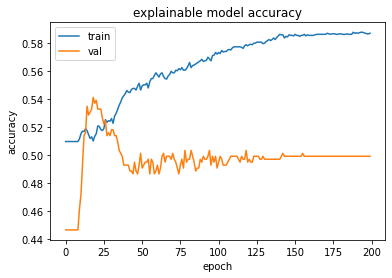

Evaluate on test data
15/15 [==============================] - 0s 10ms/step - loss: 0.7024 - act_output_loss: 0.7018 - explanation_weights_accuracy: 0.0616 - act_output_accuracy: 0.5397
test loss, test acc: [0.7024374008178711, 0.7018362283706665, 0.06161472946405411, 0.5396600365638733]


Classification Report
45/45 [==============================] - 2s 5ms/step


45/45 [==============================] - 0s 5ms/step
Epoch 1/200
3/3 [==============================] - 9s 1s/step - loss: 0.7584 - act_output_loss: 0.7550 - explanation_weights_accuracy: 0.0000e+00 - act_output_accuracy: 0.5099 - val_loss: 0.7954 - val_act_output_loss: 0.7929 - val_explanation_weights_accuracy: 0.0000e+00 - val_act_output_accuracy: 0.4442 - lr: 0.0100
Epoch 2/200
3/3 [==============================] - 0s 145ms/step - loss: 0.7411 - act_output_loss: 0.7390 - explanation_weights_accuracy: 0.0000e+00 - act_output_accuracy: 0.5099 - val_loss: 0.7743 - val_act_output_loss: 0.7728 - val_explanation_weights_accura

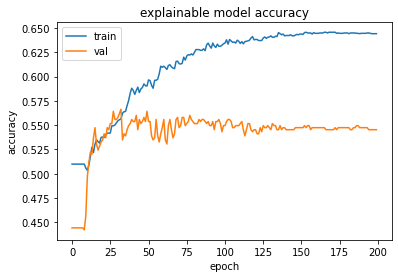

Evaluate on test data
15/15 [==============================] - 0s 10ms/step - loss: 0.6925 - act_output_loss: 0.6915 - explanation_weights_accuracy: 0.0000e+00 - act_output_accuracy: 0.5681
test loss, test acc: [0.6924871206283569, 0.6915245056152344, 0.0, 0.5680851340293884]


Classification Report
45/45 [==============================] - 2s 5ms/step


45/45 [==============================] - 0s 5ms/step
Epoch 1/200
3/3 [==============================] - 11s 1s/step - loss: 0.7777 - act_output_loss: 0.7742 - explanation_weights_accuracy: 0.0000e+00 - act_output_accuracy: 0.5106 - val_loss: 0.8230 - val_act_output_loss: 0.8204 - val_explanation_weights_accuracy: 0.0000e+00 - val_act_output_accuracy: 0.4400 - lr: 0.0100
Epoch 2/200
3/3 [==============================] - 0s 163ms/step - loss: 0.7580 - act_output_loss: 0.7558 - explanation_weights_accuracy: 0.0000e+00 - act_output_accuracy: 0.5106 - val_loss: 0.7986 - val_act_output_loss: 0.7971 - val_explanation_weights_accuracy: 0.0000e

Evaluate on test data
14/14 [==============================] - 0s 12ms/step - loss: 0.6409 - act_output_loss: 0.6388 - explanation_weights_accuracy: 0.0000e+00 - act_output_accuracy: 0.6430
test loss, test acc: [0.6408542990684509, 0.6388075351715088, 0.0, 0.6430155038833618]


Classification Report
43/43 [==============================] - 2s 6ms/step


43/43 [==============================] - 0s 5ms/step
Epoch 1/200
3/3 [==============================] - 11s 1s/step - loss: 0.7940 - act_output_loss: 0.7903 - explanation_weights_accuracy: 0.0000e+00 - act_output_accuracy: 0.5070 - val_loss: 0.8173 - val_act_output_loss: 0.8147 - val_explanation_weights_accuracy: 0.0000e+00 - val_act_output_accuracy: 0.4605 - lr: 0.0100
Epoch 2/200
3/3 [==============================] - 0s 132ms/step - loss: 0.7718 - act_output_loss: 0.7695 - explanation_weights_accuracy: 0.0000e+00 - act_output_accuracy: 0.5070 - val_loss: 0.7931 - val_act_output_loss: 0.7917 - val_explanation_weights_accuracy: 0.0000e

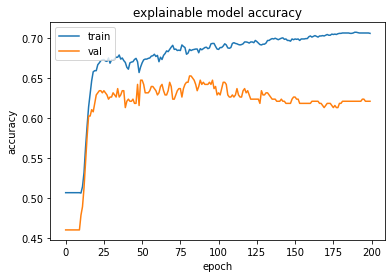

Evaluate on test data
12/12 [==============================] - 0s 13ms/step - loss: 0.6166 - act_output_loss: 0.6150 - explanation_weights_accuracy: 0.0000e+00 - act_output_accuracy: 0.6692
test loss, test acc: [0.6165683269500732, 0.6149987578392029, 0.0, 0.6692439913749695]


Classification Report
37/37 [==============================] - 2s 6ms/step


37/37 [==============================] - 0s 6ms/step
Epoch 1/200
2/2 [==============================] - 11s 2s/step - loss: 0.8038 - act_output_loss: 0.7999 - explanation_weights_accuracy: 0.0000e+00 - act_output_accuracy: 0.5083 - val_loss: 0.8428 - val_act_output_loss: 0.8398 - val_explanation_weights_accuracy: 0.0000e+00 - val_act_output_accuracy: 0.4533 - lr: 0.0100
Epoch 2/200
2/2 [==============================] - 0s 190ms/step - loss: 0.7875 - act_output_loss: 0.7846 - explanation_weights_accuracy: 0.0000e+00 - act_output_accuracy: 0.5083 - val_loss: 0.8241 - val_act_output_loss: 0.8220 - val_explanation_weights_accuracy: 0.0000e

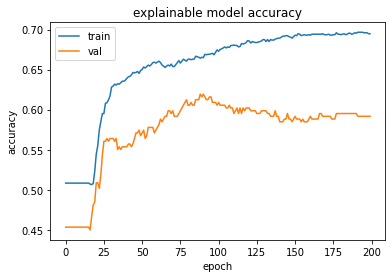

Evaluate on test data
10/10 [==============================] - 0s 14ms/step - loss: 0.6254 - act_output_loss: 0.6240 - explanation_weights_accuracy: 0.0000e+00 - act_output_accuracy: 0.6695
test loss, test acc: [0.6254251003265381, 0.6239610910415649, 0.0, 0.6694915294647217]


Classification Report
30/30 [==============================] - 2s 6ms/step


30/30 [==============================] - 0s 6ms/step
Epoch 1/200
2/2 [==============================] - 10s 2s/step - loss: 0.8334 - act_output_loss: 0.8294 - explanation_weights_accuracy: 0.0000e+00 - act_output_accuracy: 0.5016 - val_loss: 0.8277 - val_act_output_loss: 0.8246 - val_explanation_weights_accuracy: 0.0000e+00 - val_act_output_accuracy: 0.4911 - lr: 0.0100
Epoch 2/200
2/2 [==============================] - 0s 140ms/step - loss: 0.8145 - act_output_loss: 0.8115 - explanation_weights_accuracy: 0.0000e+00 - act_output_accuracy: 0.5016 - val_loss: 0.8095 - val_act_output_loss: 0.8073 - val_explanation_weights_accuracy: 0.0000e

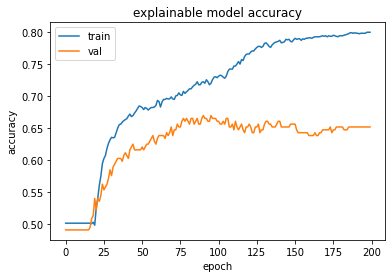

Evaluate on test data
8/8 [==============================] - 0s 14ms/step - loss: 0.7366 - act_output_loss: 0.7344 - explanation_weights_accuracy: 0.0000e+00 - act_output_accuracy: 0.6450
test loss, test acc: [0.736592710018158, 0.7343963980674744, 0.0, 0.6449864506721497]


Classification Report
24/24 [==============================] - 2s 7ms/step


24/24 [==============================] - 0s 7ms/step
Epoch 1/200
1/1 [==============================] - 10s 10s/step - loss: 0.8541 - act_output_loss: 0.8500 - explanation_weights_accuracy: 0.0000e+00 - act_output_accuracy: 0.5063 - val_loss: 0.8909 - val_act_output_loss: 0.8874 - val_explanation_weights_accuracy: 0.0000e+00 - val_act_output_accuracy: 0.4645 - lr: 0.0100
Epoch 2/200
1/1 [==============================] - 0s 247ms/step - loss: 0.8435 - act_output_loss: 0.8399 - explanation_weights_accuracy: 0.0000e+00 - act_output_accuracy: 0.5063 - val_loss: 0.8793 - val_act_output_loss: 0.8763 - val_explanation_weights_accuracy: 0.0000e+0

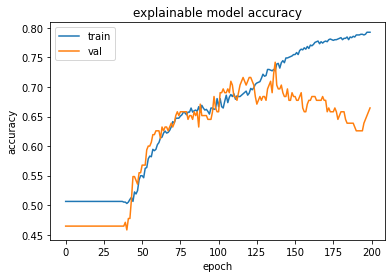

Evaluate on test data
6/6 [==============================] - 0s 15ms/step - loss: 0.6881 - act_output_loss: 0.6847 - explanation_weights_accuracy: 0.0000e+00 - act_output_accuracy: 0.6808
test loss, test acc: [0.6881412267684937, 0.6847147345542908, 0.0, 0.6808118224143982]


Classification Report
17/17 [==============================] - 3s 8ms/step


17/17 [==============================] - 0s 8ms/step
Epoch 1/200
1/1 [==============================] - 10s 10s/step - loss: 0.8862 - act_output_loss: 0.8820 - explanation_weights_accuracy: 0.0000e+00 - act_output_accuracy: 0.5008 - val_loss: 0.8758 - val_act_output_loss: 0.8722 - val_explanation_weights_accuracy: 0.0000e+00 - val_act_output_accuracy: 0.4952 - lr: 0.0100
Epoch 2/200
1/1 [==============================] - 0s 200ms/step - loss: 0.8736 - act_output_loss: 0.8700 - explanation_weights_accuracy: 0.0000e+00 - act_output_accuracy: 0.5008 - val_loss: 0.8636 - val_act_output_loss: 0.8604 - val_explanation_weights_accuracy: 0.0000e+

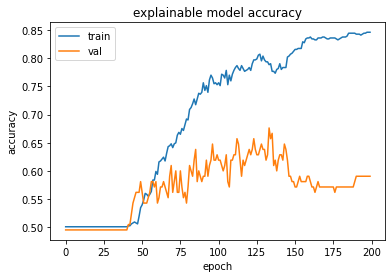

Evaluate on test data
4/4 [==============================] - 0s 16ms/step - loss: 0.8906 - act_output_loss: 0.8878 - explanation_weights_accuracy: 0.0000e+00 - act_output_accuracy: 0.5952
test loss, test acc: [0.8905697464942932, 0.8878209590911865, 0.0, 0.595174252986908]


Classification Report
12/12 [==============================] - 2s 8ms/step


12/12 [==============================] - 0s 7ms/step
Epoch 1/200
1/1 [==============================] - 9s 9s/step - loss: 0.8838 - act_output_loss: 0.8796 - explanation_weights_accuracy: 0.0000e+00 - act_output_accuracy: 0.5192 - val_loss: 1.0413 - val_act_output_loss: 1.0377 - val_explanation_weights_accuracy: 0.0000e+00 - val_act_output_accuracy: 0.3919 - lr: 0.0100
Epoch 2/200
1/1 [==============================] - 0s 184ms/step - loss: 0.8715 - act_output_loss: 0.8678 - explanation_weights_accuracy: 0.0000e+00 - act_output_accuracy: 0.5192 - val_loss: 1.0241 - val_act_output_loss: 1.0209 - val_explanation_weights_accuracy: 0.0000e+00 

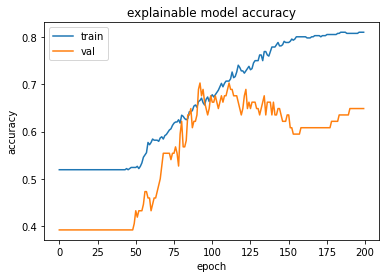

Evaluate on test data
3/3 [==============================] - 0s 18ms/step - loss: 0.7190 - act_output_loss: 0.7162 - explanation_weights_accuracy: 0.0000e+00 - act_output_accuracy: 0.6131
test loss, test acc: [0.7189971208572388, 0.7161637544631958, 0.0, 0.6131386756896973]


Classification Report
9/9 [==============================] - 3s 9ms/step


9/9 [==============================] - 0s 9ms/step
Epoch 1/200
1/1 [==============================] - 9s 9s/step - loss: 0.9403 - act_output_loss: 0.9362 - explanation_weights_accuracy: 0.0000e+00 - act_output_accuracy: 0.5017 - val_loss: 0.9397 - val_act_output_loss: 0.9361 - val_explanation_weights_accuracy: 0.0000e+00 - val_act_output_accuracy: 0.4906 - lr: 0.0100
Epoch 2/200
1/1 [==============================] - 0s 159ms/step - loss: 0.9253 - act_output_loss: 0.9217 - explanation_weights_accuracy: 0.0000e+00 - act_output_accuracy: 0.5017 - val_loss: 0.9247 - val_act_output_loss: 0.9216 - val_explanation_weights_accuracy: 0.0000e+00 - v

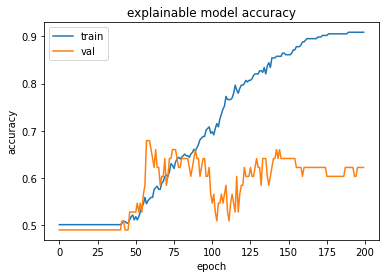

Evaluate on test data
3/3 [==============================] - 0s 16ms/step - loss: 0.8512 - act_output_loss: 0.8466 - explanation_weights_accuracy: 0.0000e+00 - act_output_accuracy: 0.6010
test loss, test acc: [0.8512446284294128, 0.846558153629303, 0.0, 0.6009615659713745]


Classification Report
7/7 [==============================] - 2s 9ms/step


7/7 [==============================] - 0s 8ms/step
Epoch 1/200
1/1 [==============================] - 9s 9s/step - loss: 0.9828 - act_output_loss: 0.9788 - explanation_weights_accuracy: 0.0000e+00 - act_output_accuracy: 0.4922 - val_loss: 0.8991 - val_act_output_loss: 0.8956 - val_explanation_weights_accuracy: 0.7714 - val_act_output_accuracy: 0.5429 - lr: 0.0100
Epoch 2/200
1/1 [==============================] - 0s 130ms/step - loss: 0.9664 - act_output_loss: 0.9629 - explanation_weights_accuracy: 0.9430 - act_output_accuracy: 0.4922 - val_loss: 0.8860 - val_act_output_loss: 0.8829 - val_explanation_weights_accuracy: 1.0000 - val_act_output

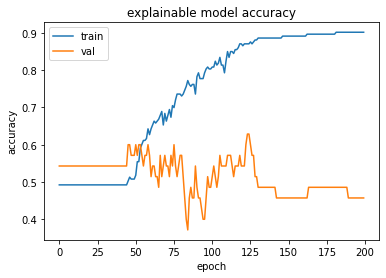

Evaluate on test data
2/2 [==============================] - 0s 19ms/step - loss: 0.7937 - act_output_loss: 0.7912 - explanation_weights_accuracy: 0.0000e+00 - act_output_accuracy: 0.6014
test loss, test acc: [0.7937167286872864, 0.7911925315856934, 0.0, 0.6013513803482056]


Classification Report
5/5 [==============================] - 2s 9ms/step


5/5 [==============================] - 0s 10ms/step
Epoch 1/200
1/1 [==============================] - 9s 9s/step - loss: 1.0169 - act_output_loss: 1.0128 - explanation_weights_accuracy: 0.0000e+00 - act_output_accuracy: 0.4923 - val_loss: 0.9230 - val_act_output_loss: 0.9195 - val_explanation_weights_accuracy: 0.0000e+00 - val_act_output_accuracy: 0.5417 - lr: 0.0100
Epoch 2/200
1/1 [==============================] - 0s 113ms/step - loss: 0.9989 - act_output_loss: 0.9953 - explanation_weights_accuracy: 0.0000e+00 - act_output_accuracy: 0.4923 - val_loss: 0.9078 - val_act_output_loss: 0.9048 - val_explanation_weights_accuracy: 0.0000e+00 - 

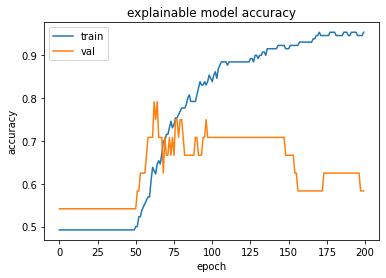

Evaluate on test data
2/2 [==============================] - 0s 11ms/step - loss: 0.7256 - act_output_loss: 0.7223 - explanation_weights_accuracy: 0.0000e+00 - act_output_accuracy: 0.6957
test loss, test acc: [0.7256457805633545, 0.7223256826400757, 0.0, 0.695652186870575]


Classification Report
4/4 [==============================] - 3s 11ms/step


4/4 [==============================] - 0s 9ms/step
Epoch 1/200
1/1 [==============================] - 9s 9s/step - loss: 1.0386 - act_output_loss: 1.0345 - explanation_weights_accuracy: 0.0000e+00 - act_output_accuracy: 0.5000 - val_loss: 1.0105 - val_act_output_loss: 1.0068 - val_explanation_weights_accuracy: 0.0000e+00 - val_act_output_accuracy: 0.5000 - lr: 0.0100
Epoch 2/200
1/1 [==============================] - 0s 87ms/step - loss: 1.0193 - act_output_loss: 1.0156 - explanation_weights_accuracy: 0.0000e+00 - act_output_accuracy: 0.5000 - val_loss: 0.9929 - val_act_output_loss: 0.9897 - val_explanation_weights_accuracy: 0.0000e+00 - va

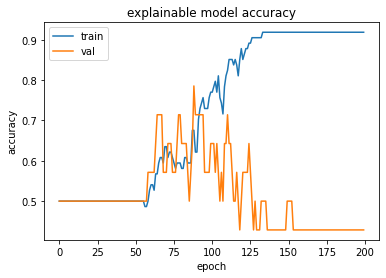

Evaluate on test data
1/1 [==============================] - 0s 39ms/step - loss: 0.8793 - act_output_loss: 0.8767 - explanation_weights_accuracy: 0.0000e+00 - act_output_accuracy: 0.7024
test loss, test acc: [0.8792986273765564, 0.876674473285675, 0.0, 0.7023809552192688]


Classification Report
3/3 [==============================] - 2s 11ms/step


3/3 [==============================] - 0s 12ms/step
Epoch 1/200
1/1 [==============================] - 9s 9s/step - loss: 1.0627 - act_output_loss: 1.0584 - explanation_weights_accuracy: 0.0000e+00 - act_output_accuracy: 0.5000 - val_loss: 1.0496 - val_act_output_loss: 1.0459 - val_explanation_weights_accuracy: 0.0000e+00 - val_act_output_accuracy: 0.5000 - lr: 0.0100
Epoch 2/200
1/1 [==============================] - 0s 84ms/step - loss: 1.0422 - act_output_loss: 1.0385 - explanation_weights_accuracy: 0.0000e+00 - act_output_accuracy: 0.5000 - val_loss: 1.0307 - val_act_output_loss: 1.0275 - val_explanation_weights_accuracy: 0.0000e+00 - v

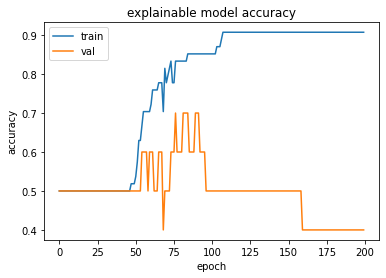

Evaluate on test data
1/1 [==============================] - 0s 34ms/step - loss: 0.9584 - act_output_loss: 0.9569 - explanation_weights_accuracy: 0.0000e+00 - act_output_accuracy: 0.4630
test loss, test acc: [0.9583911299705505, 0.9568766951560974, 0.0, 0.46296295523643494]


Classification Report
2/2 [==============================] - 2s 13ms/step


2/2 [==============================] - 0s 12ms/step


In [31]:
trained_models = []
hyperparametrs = []
trained_model_list = os.path.join(MILESTONE_DIR,'_model_list.pkl')

results_acc =[]
results_pre = []
results_rec = []
results_f1 = []
results_support = []

Results_df = pd.DataFrame(columns = ['BUCKET','ACCURACY','PRECISION','RECALL', 'F-1', 'ROC_AUC','SUPPORT'])
df_explanations = pd.DataFrame(columns = ['CASEID','FEATURE','FEATURE_VALUE','FEATURE_IMPORTANCE','BUCKET'])
df_predictions = pd.DataFrame(columns = ['CASEID','PREDICTION_PROB','PREDICTION','GROUND_TRUTH','BUCKET'])

for i in range(len(buckets)):

  bucket = buckets[i]

  #Build Model
  max_len = full_vec[bucket]['vec_train']['prefixes']['x_ac_inp'].shape[1]
  exp_dim = inputs_outputs[bucket]['input_exp_dim']
  input_train = inputs_outputs[bucket]['inputs_train']
  output_train = inputs_outputs[bucket]['outputs_train']
  opt = 'Adam' #'Nadam','Adamax','Adagrad'

  #model with hyperparameter tuning
  #self_explainable = self_explainable_model_optimum (input_train,output_train,indexes[bucket], args,exp_dim,opt, max_len)
  
  #hyperparametrs.append(self_explainable.get_config())
  #model without hyperparameter tuning

  lstm_size_alpha = 70
  lstm_size_beta = 70
  dense_1_dim = 1.5
  learning_rate = 0.01

  self_explainable = self_explainable_model(indexes[bucket], args,exp_dim, lstm_size_alpha, lstm_size_beta, dense_1_dim, learning_rate, opt,max_len) 

  plot_model(
        self_explainable,
        to_file="self explainable model.png",
        show_shapes=False,
        show_dtype=False,
        show_layer_names=True,
        rankdir="TB",
        expand_nested=False,
        dpi=96,
    )

  #Compile Model
  lambda_reg = 0.0001

  #Train Model
  batch_size = 1000 # 32, 64, 128, 256
  epochs = 200
  input_train = inputs_outputs[bucket]['inputs_train']
  output_train = inputs_outputs[bucket]['outputs_train']
  model_history = self_explainable_model_fit(input_train,output_train,args, self_explainable, MY_WORKSPACE_DIR, batch_size, epochs)
  plot_model_history(model_history) 

  output_file_path = os.path.join(MILESTONE_DIR,'_model_'+ bucket +'.pkl')
  
  # saving the trained model (for future testing)
  with open(output_file_path, 'wb') as fp:
    pickle.dump(self_explainable, fp, protocol=pickle.HIGHEST_PROTOCOL)
  
  #add the saved model name to a list (for future reference)
  trained_models.append(output_file_path)
  hyperparametrs.append(self_explainable.get_config())

  #Testing the Model and saving the macro level results as a dataframe

  input_test = inputs_outputs[bucket]['inputs_test']
  output_test = inputs_outputs[bucket]['outputs_test']
  features_exp = inputs_outputs[bucket]['explainable_feature_names']

  index_oc = indexes[bucket]['index_oc']

  report = test_model(input_test, output_test, exp_dim, features_exp,self_explainable_model,index_oc)
  #Generating Key outputs for explaining the model
  input_test, model_output_test, features_exp = model_outputs(input_test, output_test, exp_dim, features_exp,self_explainable)
  roc_auc = roc_auc_score(model_output_test['y_test'], model_output_test['y_pred'])

  Results_df_bucket = pd.DataFrame({'BUCKET': bucket,'ACCURACY': report['accuracy'],'PRECISION': report['weighted avg']['precision'],'RECALL': report['weighted avg']['recall'],
                                    'ROC_AUC':roc_auc,'F-1': report['weighted avg']['f1-score'], 'SUPPORT': report['weighted avg']['support']}, index = [i])
  Results_df = pd.concat([Results_df,Results_df_bucket])

  
  if bucket in ['1_5','1_10','1_15','1_20']:

    df_exp = pd.DataFrame(columns = ['CASEID','FEATURE','FEATURE_VALUE','FEATURE_IMPORTANCE','LAST_LAYER_WEIGHTS','BUCKET'])
    df_pred = pd.DataFrame(columns = ['CASEID','PREDICTION_PROB','PREDICTION','GROUND_TRUTH','BUCKET'])

    df_exp['CASEID'] = [case  for case in full_vec[bucket]['vec_test']['caseid'] for i in range(input_test['input_exp'].shape[1])]
    df_exp['FEATURE'] = [feature for i in range(full_vec[bucket]['vec_test']['caseid'].shape[0]) for feature in features_exp ]
    df_exp['FEATURE_VALUE'] = input_test['input_exp'].flatten()
    df_exp['FEATURE_IMPORTANCE'] = model_output_test['y_test_exp'].flatten()
    df_exp['LAST_LAYER_WEIGHTS'] =  [weight for i in range(full_vec[bucket]['vec_test']['caseid'].shape[0]) for weight in self_explainable.get_layer('act_output').get_weights()[0].T[0] ]
    df_exp['BUCKET'] = [bucket  for case in full_vec[bucket]['vec_test']['caseid'] for i in range(input_test['input_exp'].shape[1])]

    df_exp['FEATURE_IMPORTANCE'] = df_exp['FEATURE_IMPORTANCE']*df_exp['LAST_LAYER_WEIGHTS'] 
    df_exp = df_exp.drop(columns = 'LAST_LAYER_WEIGHTS')

    df_pred['CASEID'] = full_vec[bucket]['vec_test']['caseid']
    df_pred['PREDICTION_PROB'] = model_output_test['y_pred']
    df_pred['PREDICTION'] = [index_oc[int(pred>0.5)] for pred in model_output_test['y_pred'] ]
    df_pred['GROUND_TRUTH'] = [index_oc[test] for test in model_output_test['y_test'] ]
    df_pred['BUCKET'] = [bucket  for case in full_vec[bucket]['vec_test']['caseid'] ]


    df_explanations = pd.concat([df_explanations,df_exp])
    df_predictions = pd.concat([df_predictions,df_pred])

file_name_exp = os.path.join(MILESTONE_DIR,log_name+'_'+experiment+'_explanations.csv')
df_explanations.to_csv(file_name_exp)

file_name_pred = os.path.join(MILESTONE_DIR,log_name+'_'+experiment+'_predictions.csv')
df_predictions.to_csv(file_name_pred)

file_name_results = os.path.join(MILESTONE_DIR,log_name+'_'+experiment+'_results.csv')
Results_df.to_csv(file_name_results)




##### Model Results

Total Runtime of all the models is ~ 45 minutes

In [32]:
Results_df

BUCKET  ACCURACY  PRECISION    RECALL       F-1   ROC_AUC SUPPORT
0     1_5  0.531375   0.553705  0.531375  0.527187  0.580789    1498
1     1_6  0.535588   0.536502  0.535588  0.535928  0.555308    1419
2     1_7  0.539660   0.541071  0.539660  0.540053  0.552335    1412
3     1_8  0.568085   0.572000  0.568085  0.568067  0.612029    1410
4     1_9  0.643016   0.645643  0.643016  0.642234  0.707906    1353
5    1_10  0.669244   0.667928  0.669244  0.667749  0.712517    1164
6    1_11  0.669492   0.666979  0.669492  0.664668  0.700957     944
7    1_12  0.644986   0.641793  0.644986  0.641838  0.681998     738
8    1_13  0.680812   0.678383  0.680812  0.678920  0.725279     542
9    1_14  0.595174   0.613582  0.595174  0.600342  0.615111     373
10   1_15  0.613139   0.654940  0.613139  0.621125  0.665700     274
11   1_16  0.600962   0.652420  0.600962  0.613805  0.619138     208
12   1_17  0.601351   0.689174  0.601351  0.615507  0.698636     148
13   1_18  0.695652   0.730873  0.695652  0.707172  0.733810     115
14   1_19  0.702381   0.736607  0.702381  0.714886  0.672714      84
15   1_20  0.462963   0.599794  0.462963  0.466463  0.459459      54

### Model Evaluation

#### Logistic Regression

In [33]:
from sklearn.linear_model import LogisticRegression

LR_Results_df = pd.DataFrame(columns = ['BUCKET','ACCURACY','PRECISION','RECALL', 'F-1', 'ROC_AUC','SUPPORT'])

LR_Explanations_df = pd.DataFrame (columns =  ['BUCKET','FEATURE','FEATURE_WEIGHT'] )


for i in range(len(buckets)):

  bucket = buckets[i]

  X_train = inputs_outputs[bucket]['inputs_train']['input_exp']
  y_train = inputs_outputs[bucket]['outputs_train']['act_output']

  X_test = inputs_outputs[bucket]['inputs_test']['input_exp']
  y_test = inputs_outputs[bucket]['outputs_test']['act_output']

  features_exp = inputs_outputs[bucket]['explainable_feature_names']

  LR = LogisticRegression(random_state=0,max_iter=1000).fit(X_train, y_train)

  LR_path = os.path.join(os.path.join(MILESTONE_DIR,'EVAL'),'_LR_model_'+ bucket +'.pkl')
  
  # saving the trained model (for future testing)
  with open(LR_path, 'wb') as fp:
    pickle.dump(LR, fp, protocol=pickle.HIGHEST_PROTOCOL)

  index_oc = indexes[bucket]['index_oc']
  target_names = [index_oc[i] for i in range(len(index_oc))]
  y_pred= LR.predict(X_test)
  y_pred_bin = y_pred > 0.5
  y_pred_bin = y_pred_bin.astype(int)

  report = classification_report(y_test, y_pred_bin , target_names=target_names, output_dict=True)
  roc_auc = roc_auc_score(y_test, y_pred)

  LR_Results_df_bucket = pd.DataFrame({'BUCKET': bucket,'ACCURACY': report['accuracy'],'PRECISION': report['weighted avg']['precision'],'RECALL': report['weighted avg']['recall'], 
                                       'F-1': report['weighted avg']['f1-score'], 'ROC_AUC':roc_auc,'SUPPORT': report['weighted avg']['support']}, index = [i])
  LR_Results_df = pd.concat([LR_Results_df,LR_Results_df_bucket])

  LR_coef = LR.coef_[0].tolist()
  LR_prediction = [index_oc[1] for f in features_exp]
  try: LR_features = features_exp.tolist()
  except: LR_features = features_exp
  LR_exp_dict = {'BUCKET': bucket,'PREDICTION':LR_prediction, 'FEATURE': LR_features,'FEATURE_WEIGHT': LR_coef}

  LR_Explanations_df_bucket = pd.DataFrame(LR_exp_dict)
  LR_Explanations_df = pd.concat([LR_Explanations_df,LR_Explanations_df_bucket])

file_name_LR_results = os.path.join(os.path.join(MILESTONE_DIR,'EVAL'),'BPIC_2018_'+experiment+'_LR_results.csv')
LR_Results_df.to_csv(file_name_LR_results)

file_name_LR_explanations = os.path.join(os.path.join(MILESTONE_DIR,'EVAL'),'BPIC_2018_'+experiment+'_LR_explanations.csv')
LR_Explanations_df.to_csv(file_name_LR_explanations)








In [34]:
LR_Results_df

BUCKET  ACCURACY  PRECISION    RECALL       F-1   ROC_AUC SUPPORT
0     1_5  0.556742   0.591357  0.556742  0.547542  0.575211    1498
1     1_6  0.546864   0.560767  0.546864  0.540818  0.554749    1419
2     1_7  0.524079   0.536148  0.524079  0.516696  0.531775    1412
3     1_8  0.596454   0.595201  0.596454  0.591363  0.590077    1410
4     1_9  0.654841   0.654776  0.654841  0.654728  0.654518    1353
5    1_10  0.682131   0.680989  0.682131  0.680827  0.676475    1164
6    1_11  0.668432   0.666458  0.668432  0.661542  0.651850     944
7    1_12  0.684282   0.682089  0.684282  0.679823  0.670128     738
8    1_13  0.717712   0.718055  0.717712  0.709977  0.695387     542
9    1_14  0.697051   0.694489  0.697051  0.695521  0.674992     373
10   1_15  0.678832   0.696327  0.678832  0.684027  0.673122     274
11   1_16  0.735577   0.751886  0.735577  0.740880  0.722716     208
12   1_17  0.682432   0.731665  0.682432  0.693720  0.692029     148
13   1_18  0.730435   0.744340  0.730435  0.736016  0.688441     115
14   1_19  0.583333   0.682208  0.583333  0.610869  0.579365      84
15   1_20  0.462963   0.599794  0.462963  0.466463  0.528617      54

In [35]:
LR_accuracy = sum(LR_Results_df['ROC_AUC']*LR_Results_df['SUPPORT'])/sum(LR_Results_df['SUPPORT'])

In [36]:
Model_accuracy = sum(Results_df['ROC_AUC']*Results_df['SUPPORT'])/sum(Results_df['SUPPORT'])

In [37]:
print('LR accuracy: '+str(LR_accuracy))
print('Model accuracy: '+str(Model_accuracy))

LR accuracy: 0.6166366049944834
Model accuracy: 0.6352992024686408


####Deep learning Non Explainable

In [38]:
#Deep learning baseline model

def deep_baseline_model (indexes, args, exp_dim, lstm_size_alpha, lstm_size_beta, dense_1_dim, learning_rate, opt = None, max_len = None):

  EXPERIMENT = args['experiment']
  prefix_len = args['prefix_length']

  if  max_len == None:
    MAX_LEN = args['n_size']
  else:
    MAX_LEN = max_len


  incl_time = True 
  incl_res = True
    
  dropout = 0.15
  #lstm_size_alpha =  hp.Int('units', min_value=32, max_value=512, step=32) #50
  l2reg=0.0001
  dropout_input = 0.15
  dropout_context=0.15

  index_ac = indexes['index_ac']
  index_rl = indexes['index_rl']
  index_oc = indexes['index_oc']
  ac_index = indexes['ac_index']
  rl_index = indexes['rl_index']
  oc_index = indexes['oc_index']

  dim = len(ac_index)+ len(rl_index)+2
  

  raw_input = layers.Input(shape=(MAX_LEN,dim, ), name='raw_input') #Raw input x
  #raw_input = layers.Dropout(dropout)(raw_input)

  raw_input_static = layers.Input(shape = (1,), name = 'raw_input_static' ) #Static input x

  #input = layers.Input(shape=(exp_dim, ), name='exp_input') #explainable input h(x)
  #input = layers.Dropout(dropout,name='exp_input')(input)

  

  #LSTM 
  alpha = layers.Bidirectional(layers.LSTM(lstm_size_alpha, return_sequences=True),
                                        name='alpha') #timestep attention

  beta = layers.Bidirectional(layers.LSTM(lstm_size_beta, return_sequences=True),
                                   name='beta')
 
  

  #Dense layer for attention
  alpha_dense = layers.Dense(1, kernel_regularizer=l2(l2reg))

  beta_dense = layers.Dense(dim,
                                activation='tanh', kernel_regularizer=l2(l2reg))
  
  
   #Compute beta, feature attention
  beta_out = beta(raw_input)
  beta_out = layers.TimeDistributed(beta_dense, name='feature_attention_ac')(beta_out)
  c_t = layers.Multiply(name = 'feature_importance')([beta_out,raw_input])

  #Compute alpha, timestep attention

  alpha_out = alpha(raw_input)
  alpha_out = layers.TimeDistributed(alpha_dense, name='alpha_dense')(alpha_out)
  alpha_out = layers.Softmax(name='timestep_attention', axis=1)(alpha_out)

  #Compute context vector based on attentions and embeddings
  c_t = layers.Multiply()([alpha_out, c_t])
  c_t = layers.Lambda(lambda x: backend.sum(x, axis=1))(c_t)

  #concatenate static features
  c_t = layers.concatenate([c_t,raw_input_static],name = 'full_features')

  #contexts = layers.Dropout(dropout)(c_t)

  '''#Intermediate dense layer
  dense_1_dim = round(exp_dim*dense_1_dim) 

  dense_1 = layers.Dense(dense_1_dim,
                        activation='softmax',
                        kernel_initializer='glorot_uniform',
                        name='dense_1')(contexts)

  #Dense layer to compute the explainable weights thetas

  thetas = layers.Dense(exp_dim,
                        activation='softmax',
                        kernel_initializer='glorot_uniform',
                        name='explanation_weights')(dense_1)'''
 
  #initialize all the weights to one
  initializer = tf.keras.initializers.Ones()  
  act_output = layers.Dense(1,activation='sigmoid',kernel_initializer=initializer,trainable=True, name='act_output')(c_t)


  model = Model(inputs=[raw_input , raw_input_static], outputs=act_output)

  #learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  #optimizer choice

  if opt == 'Adam':
    optim = keras.optimizers.Adam(learning_rate=learning_rate)
  elif opt == 'Nadam':
    optim = keras.optimizers.Nadam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
  elif opt == 'Adamax':
    optim = keras.optimizers.Adamax(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
  elif opt == 'Adagrad':
    optim = keras.optimizers.Adagrad(learning_rate=learning_rate, initial_accumulator_value=0.1, epsilon=1e-07)
  else:
     optim = keras.optimizers.Adam(learning_rate=learning_rate) 




  model.compile(loss={'act_output': 'binary_crossentropy'}, optimizer= optim , metrics=['accuracy']) 
  
  
  return model

#-----------------------------------------------------------------------------------------------------------------------------------------------
  #Training the model

def deep_baseline_model_fit(input_train,output_train,args, deep_baseline_model, MY_WORKSPACE_DIR, batch_size, epochs):


  early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=100)

  output_file_path = os.path.join(os.path.join(MY_WORKSPACE_DIR,
                                        'models'),'model_' +args['prediction']+
                                        '_{epoch:02d}-{val_loss:.2f}.h5')
  
  lr_reducer = callbacks.ReduceLROnPlateau(monitor='val_loss',
                                    factor=0.5,
                                    patience=20,
                                    verbose=0,
                                    mode='auto',
                                    min_delta=0.0001,
                                    cooldown=0,
                                    min_lr=0)
  
  

  model_history = deep_baseline_model.fit([input_train['input_dynamic'],input_train['input_static']], output_train['act_output'],
              validation_split=0.15,
              #validation_data=(model_val_inputs, model_val_outputs),
              verbose=1,
              callbacks=[lr_reducer], #callbacks=[early_stopping, model_checkpoint,lr_reducer],
              batch_size=batch_size,
              epochs=epochs)
  
  return model_history
   
#-----------------------------------------------------------------------------------------------------------------------------------------------
#Plot Model History
def plot_deep_baseline_model_history(history):
    #Training and validation curves

    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('deep baseline model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()


#-----------------------------------------------------------------------------------------------------------------------------------------------
#Model Testing
def test_deep_baseline_model(input_test, output_test, deep_baseline_model,index_oc):

  print("Evaluate on test data")
  results = deep_baseline_model.evaluate([input_test['input_dynamic'],input_test['input_static']], output_test['act_output'], batch_size=100)
  print("test loss, test acc:", results)
  print("\n")

  print("Classification Report")
  target_names = [index_oc[i] for i in range(len(index_oc))]
  y_test = output_test['act_output']
  y_out = deep_baseline_model.predict([input_test['input_dynamic'],input_test['input_static']])
  y_pred = y_out
  y_pred_bin = y_pred > 0.5
  y_pred_bin = y_pred_bin.astype(int)

  report = classification_report(y_test, y_pred_bin , target_names=target_names, output_dict=True)
  print("\n")

  '''print("Confusion Matrix")
  matrix = confusion_matrix(y_test, y_pred_bin )

  matrix_sum = np.sum(matrix, axis=1).reshape(-1,1)
  matrix_perc = matrix / matrix_sum
  df_cm = pd.DataFrame(matrix_perc, index = target_names,
                  columns = target_names)

  plt.figure(figsize = (10,7))
  sn.heatmap(df_cm, annot=True)'''

  return report

###### Model Execution and Extraction of Explanations

Epoch 1/200
3/3 [==============================] - 9s 1000ms/step - loss: 0.8006 - accuracy: 0.4935 - val_loss: 0.8596 - val_accuracy: 0.4589 - lr: 0.0100
Epoch 2/200
3/3 [==============================] - 0s 98ms/step - loss: 0.7749 - accuracy: 0.5006 - val_loss: 0.8396 - val_accuracy: 0.4568 - lr: 0.0100
Epoch 3/200
3/3 [==============================] - 0s 100ms/step - loss: 0.7667 - accuracy: 0.5102 - val_loss: 0.8449 - val_accuracy: 0.4800 - lr: 0.0100
Epoch 4/200
3/3 [==============================] - 0s 97ms/step - loss: 0.7598 - accuracy: 0.5251 - val_loss: 0.8260 - val_accuracy: 0.4926 - lr: 0.0100
Epoch 5/200
3/3 [==============================] - 0s 99ms/step - loss: 0.7541 - accuracy: 0.5318 - val_loss: 0.8173 - val_accuracy: 0.4884 - lr: 0.0100
Epoch 6/200
3/3 [==============================] - 0s 98ms/step - loss: 0.7470 - accuracy: 0.5281 - val_loss: 0.8189 - val_accuracy: 0.4779 - lr: 0.0100
Epoch 7/200
3/3 [==============================] - 0s 99ms/step - loss: 0.7426 

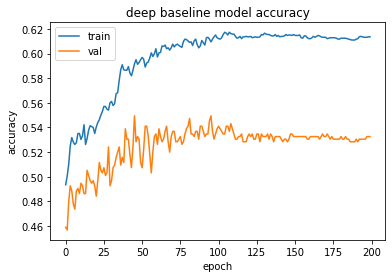

Evaluate on test data
15/15 [==============================] - 0s 8ms/step - loss: 0.7817 - accuracy: 0.5307
test loss, test acc: [0.7817100882530212, 0.530707597732544]


Classification Report
47/47 [==============================] - 2s 4ms/step


47/47 [==============================] - 2s 4ms/step
Epoch 1/200
3/3 [==============================] - 10s 996ms/step - loss: 0.7977 - accuracy: 0.4987 - val_loss: 0.8539 - val_accuracy: 0.4632 - lr: 0.0100
Epoch 2/200
3/3 [==============================] - 0s 116ms/step - loss: 0.7769 - accuracy: 0.4983 - val_loss: 0.8671 - val_accuracy: 0.4547 - lr: 0.0100
Epoch 3/200
3/3 [==============================] - 0s 115ms/step - loss: 0.7734 - accuracy: 0.4846 - val_loss: 0.8472 - val_accuracy: 0.4337 - lr: 0.0100
Epoch 4/200
3/3 [==============================] - 0s 112ms/step - loss: 0.7654 - accuracy: 0.4901 - val_loss: 0.8363 - val_accuracy: 0.4463 - lr: 0.0100
Epoch 5/200
3/3 [==============================] - 0s 113ms/step - loss: 0.7600 -

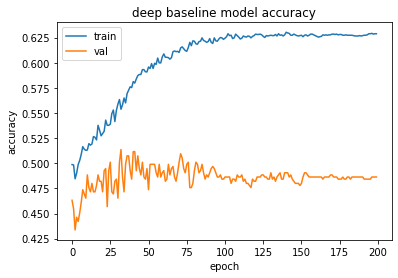

Evaluate on test data
15/15 [==============================] - 0s 9ms/step - loss: 0.8042 - accuracy: 0.5116
test loss, test acc: [0.8042254447937012, 0.5116279125213623]


Classification Report
45/45 [==============================] - 2s 4ms/step


45/45 [==============================] - 2s 4ms/step
Epoch 1/200
3/3 [==============================] - 9s 966ms/step - loss: 0.8071 - accuracy: 0.4861 - val_loss: 0.8539 - val_accuracy: 0.4695 - lr: 0.0100
Epoch 2/200
3/3 [==============================] - 0s 127ms/step - loss: 0.7840 - accuracy: 0.5017 - val_loss: 0.8474 - val_accuracy: 0.4526 - lr: 0.0100
Epoch 3/200
3/3 [==============================] - 0s 125ms/step - loss: 0.7755 - accuracy: 0.4954 - val_loss: 0.8506 - val_accuracy: 0.4695 - lr: 0.0100
Epoch 4/200
3/3 [==============================] - 0s 126ms/step - loss: 0.7697 - accuracy: 0.5006 - val_loss: 0.8382 - val_accuracy: 0.4589 - lr: 0.0100
Epoch 5/200
3/3 [==============================] - 0s 122ms/step - loss: 0.7640 -

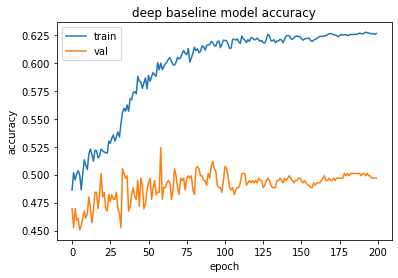

Evaluate on test data
15/15 [==============================] - 0s 9ms/step - loss: 0.8050 - accuracy: 0.5120
test loss, test acc: [0.8050232529640198, 0.5120396614074707]


Classification Report
45/45 [==============================] - 2s 4ms/step


45/45 [==============================] - 2s 4ms/step
Epoch 1/200
3/3 [==============================] - 11s 1s/step - loss: 0.7858 - accuracy: 0.5035 - val_loss: 0.8387 - val_accuracy: 0.4821 - lr: 0.0100
Epoch 2/200
3/3 [==============================] - 0s 147ms/step - loss: 0.7586 - accuracy: 0.5444 - val_loss: 0.8295 - val_accuracy: 0.4842 - lr: 0.0100
Epoch 3/200
3/3 [==============================] - 0s 142ms/step - loss: 0.7439 - accuracy: 0.5325 - val_loss: 0.8389 - val_accuracy: 0.4905 - lr: 0.0100
Epoch 4/200
3/3 [==============================] - 0s 155ms/step - loss: 0.7370 - accuracy: 0.5311 - val_loss: 0.8109 - val_accuracy: 0.5011 - lr: 0.0100
Epoch 5/200
3/3 [==============================] - 0s 141ms/step - loss: 0.7271 - a

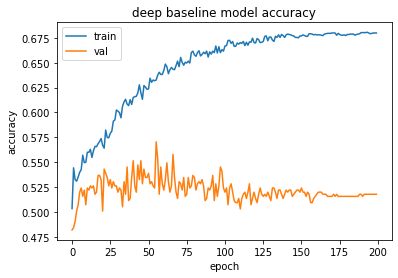

Evaluate on test data
15/15 [==============================] - 0s 12ms/step - loss: 0.7548 - accuracy: 0.5674
test loss, test acc: [0.7548497319221497, 0.567375898361206]


Classification Report
45/45 [==============================] - 2s 6ms/step


45/45 [==============================] - 2s 6ms/step
Epoch 1/200
3/3 [==============================] - 10s 1s/step - loss: 0.7936 - accuracy: 0.4927 - val_loss: 0.8395 - val_accuracy: 0.4758 - lr: 0.0100
Epoch 2/200
3/3 [==============================] - 1s 177ms/step - loss: 0.7550 - accuracy: 0.5299 - val_loss: 0.7887 - val_accuracy: 0.5516 - lr: 0.0100
Epoch 3/200
3/3 [==============================] - 1s 186ms/step - loss: 0.7165 - accuracy: 0.5716 - val_loss: 0.8252 - val_accuracy: 0.5600 - lr: 0.0100
Epoch 4/200
3/3 [==============================] - 1s 189ms/step - loss: 0.7040 - accuracy: 0.6058 - val_loss: 0.7461 - val_accuracy: 0.5937 - lr: 0.0100
Epoch 5/200
3/3 [==============================] - 1s 186ms/step - loss: 0.7012 - a

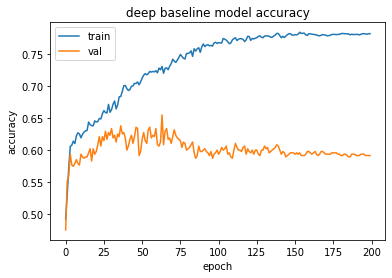

Evaluate on test data
14/14 [==============================] - 0s 15ms/step - loss: 0.7853 - accuracy: 0.6231
test loss, test acc: [0.7853348851203918, 0.623059868812561]


Classification Report
43/43 [==============================] - 2s 6ms/step


43/43 [==============================] - 2s 6ms/step
Epoch 1/200
3/3 [==============================] - 11s 1s/step - loss: 0.7626 - accuracy: 0.5293 - val_loss: 0.8089 - val_accuracy: 0.5868 - lr: 0.0100
Epoch 2/200
3/3 [==============================] - 1s 155ms/step - loss: 0.7216 - accuracy: 0.6187 - val_loss: 0.7672 - val_accuracy: 0.5921 - lr: 0.0100
Epoch 3/200
3/3 [==============================] - 1s 152ms/step - loss: 0.6867 - accuracy: 0.6411 - val_loss: 0.7842 - val_accuracy: 0.5789 - lr: 0.0100
Epoch 4/200
3/3 [==============================] - 1s 148ms/step - loss: 0.6849 - accuracy: 0.6341 - val_loss: 0.7743 - val_accuracy: 0.5526 - lr: 0.0100
Epoch 5/200
3/3 [==============================] - 1s 152ms/step - loss: 0.6727 - a

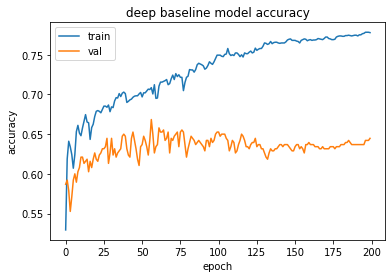

Evaluate on test data
12/12 [==============================] - 0s 19ms/step - loss: 0.7282 - accuracy: 0.6375
test loss, test acc: [0.7282302975654602, 0.6374570727348328]


Classification Report
37/37 [==============================] - 2s 7ms/step


37/37 [==============================] - 2s 7ms/step
Epoch 1/200
2/2 [==============================] - 13s 2s/step - loss: 0.7822 - accuracy: 0.5009 - val_loss: 0.8707 - val_accuracy: 0.4706 - lr: 0.0100
Epoch 2/200
2/2 [==============================] - 0s 246ms/step - loss: 0.7518 - accuracy: 0.5431 - val_loss: 0.8336 - val_accuracy: 0.5329 - lr: 0.0100
Epoch 3/200
2/2 [==============================] - 0s 219ms/step - loss: 0.7302 - accuracy: 0.5823 - val_loss: 0.8546 - val_accuracy: 0.5190 - lr: 0.0100
Epoch 4/200
2/2 [==============================] - 0s 210ms/step - loss: 0.7345 - accuracy: 0.5927 - val_loss: 0.8288 - val_accuracy: 0.5571 - lr: 0.0100
Epoch 5/200
2/2 [==============================] - 0s 235ms/step - loss: 0.7176 - 

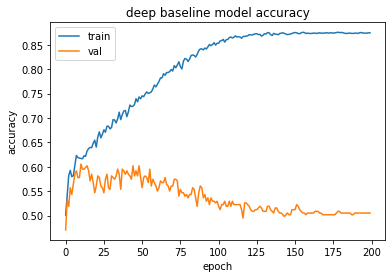

Evaluate on test data
10/10 [==============================] - 0s 14ms/step - loss: 1.1020 - accuracy: 0.5646
test loss, test acc: [1.1019501686096191, 0.5646186470985413]


Classification Report
30/30 [==============================] - 2s 7ms/step


30/30 [==============================] - 2s 7ms/step
Epoch 1/200
2/2 [==============================] - 10s 2s/step - loss: 0.7927 - accuracy: 0.5000 - val_loss: 0.8320 - val_accuracy: 0.5000 - lr: 0.0100
Epoch 2/200
2/2 [==============================] - 0s 155ms/step - loss: 0.7699 - accuracy: 0.5142 - val_loss: 0.8198 - val_accuracy: 0.4955 - lr: 0.0100
Epoch 3/200
2/2 [==============================] - 0s 151ms/step - loss: 0.7629 - accuracy: 0.5292 - val_loss: 0.8039 - val_accuracy: 0.5045 - lr: 0.0100
Epoch 4/200
2/2 [==============================] - 0s 159ms/step - loss: 0.7430 - accuracy: 0.5426 - val_loss: 0.7938 - val_accuracy: 0.5268 - lr: 0.0100
Epoch 5/200
2/2 [==============================] - 0s 155ms/step - loss: 0.7300 - 

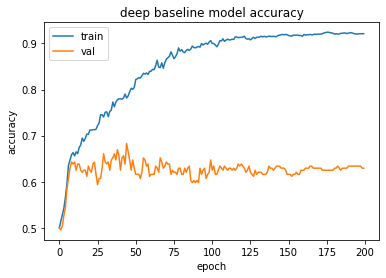

Evaluate on test data
8/8 [==============================] - 0s 15ms/step - loss: 0.9955 - accuracy: 0.6125
test loss, test acc: [0.9954793453216553, 0.6124660968780518]


Classification Report
24/24 [==============================] - 2s 8ms/step


24/24 [==============================] - 2s 8ms/step
Epoch 1/200
1/1 [==============================] - 13s 13s/step - loss: 0.8028 - accuracy: 0.5040 - val_loss: 0.8609 - val_accuracy: 0.4903 - lr: 0.0100
Epoch 2/200
1/1 [==============================] - 0s 291ms/step - loss: 0.7918 - accuracy: 0.4994 - val_loss: 0.8445 - val_accuracy: 0.5226 - lr: 0.0100
Epoch 3/200
1/1 [==============================] - 0s 293ms/step - loss: 0.7771 - accuracy: 0.5040 - val_loss: 0.8353 - val_accuracy: 0.5226 - lr: 0.0100
Epoch 4/200
1/1 [==============================] - 0s 311ms/step - loss: 0.7769 - accuracy: 0.5109 - val_loss: 0.8310 - val_accuracy: 0.5226 - lr: 0.0100
Epoch 5/200
1/1 [==============================] - 0s 304ms/step - loss: 0.7705 - a

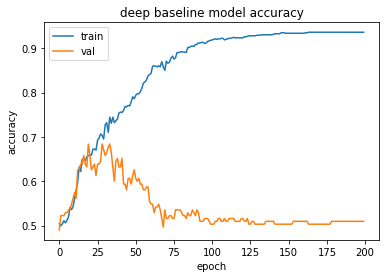

Evaluate on test data
6/6 [==============================] - 0s 17ms/step - loss: 1.1251 - accuracy: 0.5849
test loss, test acc: [1.125086784362793, 0.5848708748817444]


Classification Report
17/17 [==============================] - 2s 8ms/step


17/17 [==============================] - 2s 8ms/step
Epoch 1/200
1/1 [==============================] - 10s 10s/step - loss: 0.8107 - accuracy: 0.4958 - val_loss: 0.7853 - val_accuracy: 0.5048 - lr: 0.0100
Epoch 2/200
1/1 [==============================] - 0s 231ms/step - loss: 0.8161 - accuracy: 0.5076 - val_loss: 0.7574 - val_accuracy: 0.5619 - lr: 0.0100
Epoch 3/200
1/1 [==============================] - 0s 241ms/step - loss: 0.7863 - accuracy: 0.5093 - val_loss: 0.7623 - val_accuracy: 0.5524 - lr: 0.0100
Epoch 4/200
1/1 [==============================] - 0s 243ms/step - loss: 0.7935 - accuracy: 0.5127 - val_loss: 0.7473 - val_accuracy: 0.5619 - lr: 0.0100
Epoch 5/200
1/1 [==============================] - 0s 239ms/step - loss: 0.7795 - ac

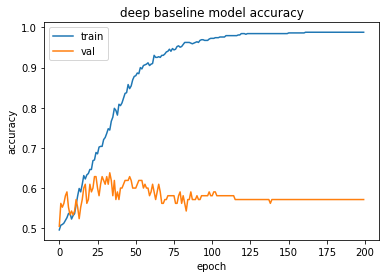

Evaluate on test data
4/4 [==============================] - 0s 19ms/step - loss: 1.0989 - accuracy: 0.5925
test loss, test acc: [1.098879098892212, 0.5924932956695557]


Classification Report
12/12 [==============================] - 2s 8ms/step


12/12 [==============================] - 2s 9ms/step
Epoch 1/200
1/1 [==============================] - 13s 13s/step - loss: 0.7847 - accuracy: 0.5072 - val_loss: 0.9900 - val_accuracy: 0.3919 - lr: 0.0100
Epoch 2/200
1/1 [==============================] - 0s 201ms/step - loss: 0.8424 - accuracy: 0.5337 - val_loss: 0.9167 - val_accuracy: 0.4730 - lr: 0.0100
Epoch 3/200
1/1 [==============================] - 0s 200ms/step - loss: 0.7706 - accuracy: 0.5529 - val_loss: 0.8790 - val_accuracy: 0.5405 - lr: 0.0100
Epoch 4/200
1/1 [==============================] - 0s 195ms/step - loss: 0.7680 - accuracy: 0.5216 - val_loss: 0.8682 - val_accuracy: 0.5405 - lr: 0.0100
Epoch 5/200
1/1 [==============================] - 0s 192ms/step - loss: 0.7720 - ac

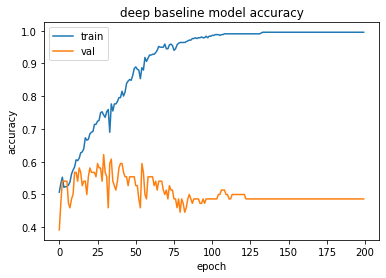

Evaluate on test data
3/3 [==============================] - 0s 24ms/step - loss: 1.6799 - accuracy: 0.4964
test loss, test acc: [1.6799041032791138, 0.49635037779808044]


Classification Report
9/9 [==============================] - 2s 10ms/step


9/9 [==============================] - 2s 9ms/step
Epoch 1/200
1/1 [==============================] - 10s 10s/step - loss: 0.7828 - accuracy: 0.5017 - val_loss: 0.7971 - val_accuracy: 0.5660 - lr: 0.0100
Epoch 2/200
1/1 [==============================] - 0s 184ms/step - loss: 0.7757 - accuracy: 0.5593 - val_loss: 0.7766 - val_accuracy: 0.6038 - lr: 0.0100
Epoch 3/200
1/1 [==============================] - 0s 173ms/step - loss: 0.7512 - accuracy: 0.5424 - val_loss: 0.7700 - val_accuracy: 0.6038 - lr: 0.0100
Epoch 4/200
1/1 [==============================] - 0s 174ms/step - loss: 0.7422 - accuracy: 0.5424 - val_loss: 0.7574 - val_accuracy: 0.6038 - lr: 0.0100
Epoch 5/200
1/1 [==============================] - 0s 165ms/step - loss: 0.7245 - acc

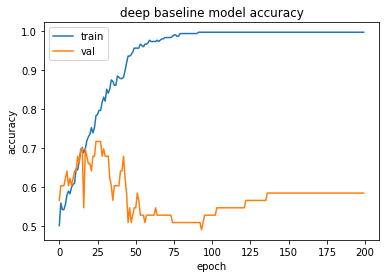

Evaluate on test data
3/3 [==============================] - 0s 15ms/step - loss: 1.2924 - accuracy: 0.6683
test loss, test acc: [1.2924085855484009, 0.6682692170143127]


Classification Report
7/7 [==============================] - 2s 10ms/step


7/7 [==============================] - 2s 11ms/step
Epoch 1/200
1/1 [==============================] - 10s 10s/step - loss: 0.7740 - accuracy: 0.5078 - val_loss: 0.9454 - val_accuracy: 0.5143 - lr: 0.0100
Epoch 2/200
1/1 [==============================] - 0s 138ms/step - loss: 0.7470 - accuracy: 0.5233 - val_loss: 0.9274 - val_accuracy: 0.6286 - lr: 0.0100
Epoch 3/200
1/1 [==============================] - 0s 147ms/step - loss: 0.7361 - accuracy: 0.5492 - val_loss: 0.9193 - val_accuracy: 0.6000 - lr: 0.0100
Epoch 4/200
1/1 [==============================] - 0s 139ms/step - loss: 0.7224 - accuracy: 0.5803 - val_loss: 0.9193 - val_accuracy: 0.6000 - lr: 0.0100
Epoch 5/200
1/1 [==============================] - 0s 139ms/step - loss: 0.6904 - acc

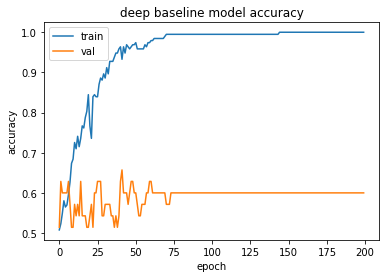

Evaluate on test data
2/2 [==============================] - 0s 17ms/step - loss: 1.4647 - accuracy: 0.5946
test loss, test acc: [1.464661717414856, 0.5945945978164673]


Classification Report
5/5 [==============================] - 2s 10ms/step


5/5 [==============================] - 2s 9ms/step
Epoch 1/200
1/1 [==============================] - 11s 11s/step - loss: 0.8223 - accuracy: 0.4692 - val_loss: 0.7996 - val_accuracy: 0.5833 - lr: 0.0100
Epoch 2/200
1/1 [==============================] - 0s 124ms/step - loss: 0.8002 - accuracy: 0.5615 - val_loss: 0.7977 - val_accuracy: 0.5833 - lr: 0.0100
Epoch 3/200
1/1 [==============================] - 0s 116ms/step - loss: 0.7517 - accuracy: 0.5462 - val_loss: 0.7978 - val_accuracy: 0.5833 - lr: 0.0100
Epoch 4/200
1/1 [==============================] - 0s 120ms/step - loss: 0.7433 - accuracy: 0.5769 - val_loss: 0.7425 - val_accuracy: 0.5833 - lr: 0.0100
Epoch 5/200
1/1 [==============================] - 0s 120ms/step - loss: 0.6992 - accur

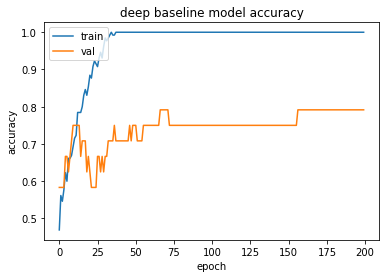

Evaluate on test data
2/2 [==============================] - 0s 17ms/step - loss: 1.2995 - accuracy: 0.6522
test loss, test acc: [1.2994787693023682, 0.6521739363670349]


Classification Report
4/4 [==============================] - 2s 11ms/step


4/4 [==============================] - 2s 11ms/step
Epoch 1/200
1/1 [==============================] - 12s 12s/step - loss: 0.8025 - accuracy: 0.4730 - val_loss: 0.6987 - val_accuracy: 0.7143 - lr: 0.0100
Epoch 2/200
1/1 [==============================] - 0s 100ms/step - loss: 0.7856 - accuracy: 0.4865 - val_loss: 0.6799 - val_accuracy: 0.7143 - lr: 0.0100
Epoch 3/200
1/1 [==============================] - 0s 105ms/step - loss: 0.7553 - accuracy: 0.5135 - val_loss: 0.7054 - val_accuracy: 0.7143 - lr: 0.0100
Epoch 4/200
1/1 [==============================] - 0s 106ms/step - loss: 0.7061 - accuracy: 0.5270 - val_loss: 0.7449 - val_accuracy: 0.7143 - lr: 0.0100
Epoch 5/200
1/1 [==============================] - 0s 97ms/step - loss: 0.6637 - accu

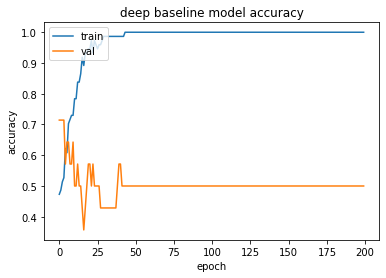

Evaluate on test data
1/1 [==============================] - 0s 43ms/step - loss: 1.3186 - accuracy: 0.5833
test loss, test acc: [1.3185813426971436, 0.5833333134651184]


Classification Report
3/3 [==============================] - 2s 13ms/step


3/3 [==============================] - 2s 13ms/step
Epoch 1/200
1/1 [==============================] - 13s 13s/step - loss: 0.7820 - accuracy: 0.5185 - val_loss: 0.9041 - val_accuracy: 0.6000 - lr: 0.0100
Epoch 2/200
1/1 [==============================] - 0s 100ms/step - loss: 0.7908 - accuracy: 0.5741 - val_loss: 0.9197 - val_accuracy: 0.6000 - lr: 0.0100
Epoch 3/200
1/1 [==============================] - 0s 102ms/step - loss: 0.7420 - accuracy: 0.5556 - val_loss: 0.9330 - val_accuracy: 0.6000 - lr: 0.0100
Epoch 4/200
1/1 [==============================] - 0s 90ms/step - loss: 0.7342 - accuracy: 0.5185 - val_loss: 0.9499 - val_accuracy: 0.6000 - lr: 0.0100
Epoch 5/200
1/1 [==============================] - 0s 89ms/step - loss: 0.7131 - accur

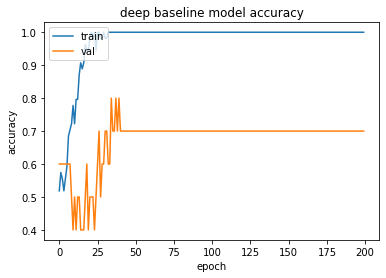

Evaluate on test data
1/1 [==============================] - 0s 38ms/step - loss: 1.4402 - accuracy: 0.6111
test loss, test acc: [1.4401953220367432, 0.6111111044883728]


Classification Report
2/2 [==============================] - 2s 15ms/step




2/2 [==============================] - 2s 14ms/step


In [39]:
trained_models = []
trained_model_list = os.path.join(os.path.join(MILESTONE_DIR,'EVAL'),'_model_list.pkl')

results_acc =[]
results_pre = []
results_rec = []
results_f1 = []
results_support = []

DL_Results_df = pd.DataFrame(columns = ['BUCKET','ACCURACY','PRECISION','RECALL', 'F-1','ROC_AUC', 'SUPPORT'])
DL_df_explanations = pd.DataFrame(columns = ['CASEID','FEATURE','FEATURE_VALUE','FEATURE_IMPORTANCE','BUCKET'])
DL_df_predictions = pd.DataFrame(columns = ['CASEID','PREDICTION_PROB','PREDICTION','GROUND_TRUTH','BUCKET'])


for i in range(len(buckets)):

  bucket = buckets[i]

  #Build Model
  max_len = full_vec[bucket]['vec_train']['prefixes']['x_ac_inp'].shape[1]
  exp_dim = inputs_outputs[bucket]['input_exp_dim']
  input_train = inputs_outputs[bucket]['inputs_train']
  output_train = inputs_outputs[bucket]['outputs_train']
  opt = 'Adam' #'Nadam','Adamax','Adagrad'

  #model with hyperparameter tuning
  #self_explainable = self_explainable_model_optimum (input_train,output_train,indexes[bucket], args,exp_dim,opt, max_len)

  #use the same hyperparameters as previous model

  lstm_size_alpha = hyperparametrs[i]['layers'][1]['config']['layer']['config']['units']
  lstm_size_beta = hyperparametrs[i]['layers'][3]['config']['layer']['config']['units']
  dense_1_dim = 1.5
  learning_rate = 0.01

  deep_baseline = deep_baseline_model(indexes[bucket], args,exp_dim, lstm_size_alpha, lstm_size_beta, dense_1_dim, learning_rate, opt,max_len) 
  plot_model(
        deep_baseline,
        to_file="deep_baseline_model.png",
        show_shapes=False,
        show_dtype=False,
        show_layer_names=True,
        rankdir="TB",
        expand_nested=False,
        dpi=96,
    )

  #Compile Model
  lambda_reg = 0.0001

  #Train Model
  batch_size = 1000 # 32, 64, 128, 256
  epochs = 200
  input_train = inputs_outputs[bucket]['inputs_train']
  output_train = inputs_outputs[bucket]['outputs_train']
  model_history = deep_baseline_model_fit(input_train,output_train,args, deep_baseline, MY_WORKSPACE_DIR, batch_size, epochs)
  plot_deep_baseline_model_history(model_history) 

  output_file_path = os.path.join(os.path.join(MILESTONE_DIR,'EVAL'),'_DL_model_'+ bucket +'.pkl')
  
  # saving the trained model (for future testing)
  with open(output_file_path, 'wb') as fp:
    pickle.dump(deep_baseline, fp, protocol=pickle.HIGHEST_PROTOCOL)
  
  #add the saved model name to a list (for future reference)
  trained_models.append(output_file_path)

  #Testing the Model and saving the macro level results as a dataframe

  input_test = inputs_outputs[bucket]['inputs_test']
  output_test = inputs_outputs[bucket]['outputs_test']
  features_exp = inputs_outputs[bucket]['explainable_feature_names']

  index_oc = indexes[bucket]['index_oc']
  report = test_deep_baseline_model(input_test, output_test, deep_baseline,index_oc) 

  #Get the attention weights from the model

  model_attn_weights = Model(inputs=deep_baseline.input,
              outputs=[deep_baseline.output, deep_baseline.get_layer('timestep_attention').output,deep_baseline.get_layer('feature_importance').output])

  output_with_attention = model_attn_weights.predict([input_test['input_dynamic'],input_test['input_static']])

  #Predictions
  y_pred = output_with_attention[0]
  y_pred = [pred[0] for pred in y_pred ]
  roc_auc = roc_auc_score(full_vec[bucket]['vec_test']['outcome'], y_pred)
  DL_Results_df_bucket = pd.DataFrame({'BUCKET': bucket,'ACCURACY': report['accuracy'],'PRECISION': report['weighted avg']['precision'],
                                       'RECALL': report['weighted avg']['recall'], 
                                       'F-1': report['weighted avg']['f1-score'], 'ROC_AUC': roc_auc, 'SUPPORT': report['weighted avg']['support']}, index = [i])
  DL_Results_df = pd.concat([DL_Results_df,DL_Results_df_bucket])

  #Feature Importance
  feat_importance = output_with_attention[1]*output_with_attention[2]

  #Feature Names
  feature_names = []
  ac_names =  [item[0] for item in indexes[bucket]['ac_index'].items()]
  feature_names.extend(ac_names)
  role_names = [item[0] for item in indexes[bucket]['rl_index'].items()]
  feature_names.extend(role_names)
  feature_names.extend(['t','t_dur'])
  features_raw = [item+'_'+str(i) for i in range(input_test['input_dynamic'].shape[1]) for item in feature_names] 
  features_raw = np.asarray(features_raw)
  
  if bucket in ['1_5','1_10','1_15','1_20']:

    #df_pred
    df_pred = pd.DataFrame(columns = ['CASEID','PREDICTION_PROB','PREDICTION','GROUND_TRUTH','BUCKET'])
    df_pred['CASEID'] = full_vec[bucket]['vec_test']['caseid']
    df_pred['PREDICTION_PROB'] = y_pred
    df_pred['PREDICTION'] = [index_oc[int(pred>0.5)] for pred in y_pred ]
    df_pred['GROUND_TRUTH'] = [index_oc[test] for test in full_vec[bucket]['vec_test']['outcome'] ]
    df_pred['BUCKET'] = bucket

    #df_exp
    df_exp = pd.DataFrame(columns = ['CASEID','FEATURE','FEATURE_VALUE','FEATURE_IMPORTANCE','BUCKET'])
    df_exp['CASEID'] = [case  for case in full_vec[bucket]['vec_test']['caseid'] for i in range(input_test['input_dynamic'].shape[1]*input_test['input_dynamic'].shape[2])]
    df_exp['FEATURE'] = [feature for i in range(full_vec[bucket]['vec_test']['caseid'].shape[0]) for feature in features_raw ]
    df_exp['FEATURE_VALUE'] = input_test['input_dynamic'].flatten()
    df_exp['FEATURE_IMPORTANCE'] = feat_importance.flatten()
    df_exp['BUCKET'] = bucket

    DL_df_explanations = pd.concat([DL_df_explanations,df_exp])
    DL_df_predictions = pd.concat([DL_df_predictions,df_pred])



file_name_exp = os.path.join(os.path.join(MILESTONE_DIR,'EVAL'),log_name+'_'+experiment+'_DL_explanations.csv')
DL_df_explanations.to_csv(file_name_exp)

file_name_pred = os.path.join(os.path.join(MILESTONE_DIR,'EVAL'),log_name+'_'+experiment+'_DL_predictions.csv')
DL_df_predictions.to_csv(file_name_pred)

file_name_results = os.path.join(os.path.join(MILESTONE_DIR,'EVAL'),log_name+'_'+experiment+'_DL_results.csv')
DL_Results_df.to_csv(file_name_results)


In [40]:
DL_Results_df

BUCKET  ACCURACY  PRECISION    RECALL       F-1   ROC_AUC SUPPORT
0     1_5  0.530708   0.542604  0.530708  0.531362  0.553658    1498
1     1_6  0.511628   0.513385  0.511628  0.512120  0.512331    1419
2     1_7  0.512040   0.510371  0.512040  0.510775  0.510297    1412
3     1_8  0.567376   0.567903  0.567376  0.567584  0.601465    1410
4     1_9  0.623060   0.625212  0.623060  0.622362  0.681833    1353
5    1_10  0.637457   0.636309  0.637457  0.636612  0.684224    1164
6    1_11  0.564619   0.574764  0.564619  0.566124  0.618804     944
7    1_12  0.612466   0.622102  0.612466  0.614008  0.680438     738
8    1_13  0.584871   0.604185  0.584871  0.586564  0.664089     542
9    1_14  0.592493   0.608962  0.592493  0.597456  0.605564     373
10   1_15  0.496350   0.562348  0.496350  0.503028  0.577632     274
11   1_16  0.668269   0.692971  0.668269  0.676302  0.689161     208
12   1_17  0.594595   0.648917  0.594595  0.609210  0.650256     148
13   1_18  0.652174   0.679072  0.652174  0.662692  0.625753     115
14   1_19  0.583333   0.670139  0.583333  0.610005  0.642479      84
15   1_20  0.611111   0.707407  0.611111  0.623455  0.678855      54